# Написанные человеком и проверенные эксперименты

## Вспомогательные функции

In [1]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple

import math
import numpy as np
import torch
from PIL import Image

import matplotlib.pyplot as plt


# -------------------------
# Image conversions
# -------------------------

def pil_to_np_bgr(pil: Image.Image) -> np.ndarray:
    """PIL RGB -> np.uint8 BGR (H,W,3) for ultralytics predictor preprocess."""
    if pil.mode != "RGB":
        pil = pil.convert("RGB")
    rgb = np.asarray(pil)  # uint8 RGB
    bgr = rgb[..., ::-1].copy()
    return bgr


def pil_to_torch_rgb01(pil: Image.Image) -> torch.Tensor:
    """PIL -> torch float32 RGB in [0,1], shape [3,H,W] (CPU)."""
    if pil.mode != "RGB":
        pil = pil.convert("RGB")
    arr = np.asarray(pil).astype(np.float32) / 255.0
    t = torch.from_numpy(arr).permute(2, 0, 1).contiguous()
    return t


# -------------------------
# Patch application
# -------------------------

def apply_patch_to_image(
    base_pil: Image.Image,
    patch_pil: Image.Image,
    position_xy: Tuple[int, int] = (0, 0),
) -> Tuple[Image.Image, Optional[torch.Tensor], int]:
    """Paste patch onto base image at (x,y). Returns patched PIL, bbox_xyxy, area_px."""
    if base_pil.mode != "RGB":
        base_pil = base_pil.convert("RGB")
    if patch_pil.mode != "RGB":
        patch_pil = patch_pil.convert("RGB")
    base_w, base_h = base_pil.size
    patch_w, patch_h = patch_pil.size
    x, y = position_xy
    x1 = max(0, int(x))
    y1 = max(0, int(y))
    x2 = min(base_w, int(x) + patch_w)
    y2 = min(base_h, int(y) + patch_h)
    if x2 <= x1 or y2 <= y1:
        return base_pil.copy(), None, 0
    # Crop patch if it spills outside the base image.
    px1 = x1 - int(x)
    py1 = y1 - int(y)
    px2 = px1 + (x2 - x1)
    py2 = py1 + (y2 - y1)
    patch_crop = patch_pil.crop((px1, py1, px2, py2))
    out = base_pil.copy()
    out.paste(patch_crop, (x1, y1))
    bbox = torch.tensor([float(x1), float(y1), float(x2), float(y2)], dtype=torch.float32)
    area = int((x2 - x1) * (y2 - y1))
    return out, bbox, area


def letterbox_pil(pil: Image.Image, imgsz: int, color: Tuple[int, int, int] = (114, 114, 114)) -> Image.Image:
    """Resize+pad image to square imgsz, matching Ultralytics letterbox behavior."""
    if pil.mode != "RGB":
        pil = pil.convert("RGB")
    w, h = pil.size
    r = min(imgsz / h, imgsz / w)
    new_w = int(round(w * r))
    new_h = int(round(h * r))
    resized = pil.resize((new_w, new_h), Image.BILINEAR)
    out = Image.new("RGB", (imgsz, imgsz), color)
    pad_w = int((imgsz - new_w) / 2)
    pad_h = int((imgsz - new_h) / 2)
    out.paste(resized, (pad_w, pad_h))
    return out

from pathlib import Path
import random
from typing import List


def collect_images(
    folder: Path,
    n: int,
    extensions: tuple[str, ...] = (".png", ".jpg", ".jpeg"),
    shuffle: bool = False,
    seed: int | None = 42,
) -> List[str]:
    """
    Берёт n изображений из папки.
    Если shuffle=True — случайная выборка (с фиксируемым seed).
    """
    files = [
        p for p in folder.iterdir()
        if p.is_file() and p.suffix.lower() in extensions
    ]

    if not files:
        raise RuntimeError(f"В папке {folder} нет изображений")

    if shuffle:
        if seed is not None:
            random.seed(seed)
        random.shuffle(files)

    return [str(p) for p in files[:n]]

In [2]:
def _load_ultralytics_yolo(model_path: str):
    try:
        from ultralytics import YOLO
    except Exception as e:
        raise RuntimeError(
            "Не удалось импортировать ultralytics. Установите пакет ultralytics или убедитесь, что среда активна."
        ) from e
    return YOLO(model_path)


def _get_class_id_from_names(names: Dict[int, str], class_name: str) -> Optional[int]:
    class_name = class_name.lower().strip()
    for k, v in names.items():
        if str(v).lower().strip() == class_name:
            return int(k)
    return None


@torch.no_grad()
def yolo_predict_conf_scalar(
    yolo_model,
    pil_img: Image.Image,
    imgsz: int,
    target_class_id: Optional[int],
    conf: float = 0.001,
) -> Tuple[float, Any]:
    """Ultralytics predict -> scalar confidence (NMS-based) + raw Results."""
    bgr = pil_to_np_bgr(pil_img)
    res = yolo_model.predict(source=bgr, imgsz=imgsz, conf=conf, verbose=False)[0]

    if res.boxes is None or len(res.boxes) == 0:
        return 0.0, res

    confs = res.boxes.conf.detach().cpu().numpy()
    clss = res.boxes.cls.detach().cpu().numpy().astype(int)

    if target_class_id is None:
        return float(confs.max(initial=0.0)), res

    mask = (clss == int(target_class_id))
    if not np.any(mask):
        return 0.0, res

    return float(confs[mask].max(initial=0.0)), res

In [24]:
def build_clean_and_patched_letterboxed(
    base_pil: Image.Image,
    patch_pil: Image.Image,
    cfg: ExpConfig,
) -> Tuple[Image.Image, Image.Image, Optional[torch.Tensor]]:
    clean_lb = letterbox_pil(base_pil, imgsz=cfg.imgsz)

    if cfg.apply_patch_after_letterbox:
        patched_lb, bbox, _ = apply_patch_to_image(clean_lb, patch_pil, cfg.patch_xy)
        return clean_lb, patched_lb, bbox

    patched_orig, _bbox_orig, _ = apply_patch_to_image(base_pil, patch_pil, cfg.patch_xy)
    patched_lb = letterbox_pil(patched_orig, imgsz=cfg.imgsz)
    return clean_lb, patched_lb, None

def pick_center_person_bbox_from_results(res, target_class_id: int, imgsz: int):
    """
    Pick the detected person bbox (post-NMS) closest to image center.
    Returns dict: {picked_bbox: [x1,y1,x2,y2], picked_conf: float, picked_idx: int}
    or {} if no person found.
    """
    if res is None or getattr(res, "boxes", None) is None or len(res.boxes) == 0:
        return {}

    xyxy = res.boxes.xyxy.detach().cpu().numpy()          # (N,4)
    conf = res.boxes.conf.detach().cpu().numpy()          # (N,)
    cls  = res.boxes.cls.detach().cpu().numpy().astype(int)  # (N,)

    m = (cls == int(target_class_id))
    if not np.any(m):
        return {}

    xyxy_p = xyxy[m]
    conf_p = conf[m]

    cx = 0.5 * (xyxy_p[:, 0] + xyxy_p[:, 2])
    cy = 0.5 * (xyxy_p[:, 1] + xyxy_p[:, 3])
    dx = cx - (float(imgsz) * 0.5)
    dy = cy - (float(imgsz) * 0.5)
    d2 = dx * dx + dy * dy

    j = int(np.argmin(d2))

    idxs = np.flatnonzero(m)
    picked_idx = int(idxs[j])

    return {
        "picked_bbox": [float(v) for v in xyxy_p[j].tolist()],
        "picked_conf": float(conf_p[j]),
        "picked_idx": picked_idx,
    }

## Параметры экспериментов

In [4]:
N_SUCCESS = 10
N_FAIL = 10
SEED=17

# successful_dir = Path("../stats/attack_split/success")
# unsuccessful_dir = Path("../stats/attack_split/fail")

successful_dir = Path("successful_examples")
unsuccessful_dir = Path("unsuccessful_examples")

image_paths = (
    collect_images(successful_dir, N_SUCCESS, shuffle=True, seed=SEED)
    + collect_images(unsuccessful_dir, N_FAIL, shuffle=True, seed=SEED)
)
patch_path = "data/patch.png"

In [5]:
@dataclass
class ExpConfig:
    # путь к весам (можно заменить на локальный)
    model_path: str = "yolo11s.pt"

    # размер входа
    imgsz: int = 640

    # устройство
    device: str = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

    # True: накладываем патч уже на letterbox-изображение (самый честный режим)
    # False: накладываем на оригинал, потом делаем letterbox
    apply_patch_after_letterbox: bool = True

    # позиция патча (x,y) в координатах того изображения, куда накладываем
    patch_xy: Tuple[int, int] = (0, 0)

    # целевой класс (None => берём max по всем классам)
    target_class_name: Optional[str] = "person"

    # успех атаки: падение скаляра уверенности >= threshold
    success_thresh: float = 0.30

    # число каналов, используемое в top-k метриках и в абляциях
    topk_channels: int = 32

    # ROI scalar reduction for attribution: "max" | "logsumexp" | "topk_mean"
    roi_reduce: str = "logsumexp"

    # temperature for logsumexp (larger -> closer to max)
    roi_lse_temp: float = 20.0

    # k for topk_mean
    roi_topk: int = 10

    # --- ROI attribution layer selection ---
    # How many layers to keep for ROI-attribution (set 1 to mimic the previous "single good layer" behavior)
    roi_keep_topk_layers: int = 1

    # How many near-head conv layers to consider as candidates
    roi_candidate_last_n_layers: int = 8

    # How many examples from each group (success/fail) to use for scanning grad signal
    roi_scan_n_per_group: int = 2

    # Minimum median ma_abs.max required to accept a layer (0.0 keeps the best even if tiny)
    roi_min_grad_strength: float = 0.0

CFG = ExpConfig()

## Подсчет разности фич между атакованным и чистым примерами

Берем хуками выходы предпоследних слоев модели и считаем:
- `F_l(clean)` и `F_l(patched)` для набора слоёв `l`
- `Δ_l = F_l(patched) - F_l(clean)`

In [6]:
import torch.nn as nn


def pick_default_conv_layers(model_torch: nn.Module, n_layers: int = 12) -> List[str]:
    convs: List[str] = []
    for n, m in model_torch.named_modules():
        if isinstance(m, nn.Conv2d):
            convs.append(n)
    if not convs:
        raise RuntimeError("Не удалось найти Conv2d модули в модели.")

    idxs = np.linspace(0, len(convs) - 1, num=min(n_layers, len(convs))).round().astype(int)
    picked = []
    seen = set()
    for i in idxs:
        name = convs[int(i)]
        if name not in seen:
            picked.append(name)
            seen.add(name)
    return picked


def get_module_by_name(model_torch: nn.Module, name: str) -> nn.Module:
    d = dict(model_torch.named_modules())
    if name not in d:
        raise KeyError(f"Layer '{name}' not found.")
    return d[name]


@torch.no_grad()
def torch_preprocess_letterboxed(pil_img_lb: Image.Image, device: str, dtype: torch.dtype) -> torch.Tensor:
    """Preprocess PIL -> BCHW tensor on the requested device/dtype."""
    t = pil_to_torch_rgb01(pil_img_lb)  # CPU float32 [3,H,W]
    t = t.unsqueeze(0)  # [1,3,H,W]
    return t.to(device=device, dtype=dtype, non_blocking=False)


def capture_activations_for_layers(
    model_torch: nn.Module,
    x_bchw: torch.Tensor,
    layer_names: List[str],
) -> Dict[str, torch.Tensor]:
    acts: Dict[str, torch.Tensor] = {}
    hooks = []

    def _mk_hook(name: str):
        def _hook(_m, _inp, out):
            # Some Ultralytics blocks can emit tuples/lists; take the first tensor.
            if isinstance(out, (list, tuple)):
                for o in out:
                    if isinstance(o, torch.Tensor):
                        out = o
                        break

            # We focus on spatial feature maps (B,C,H,W). Skip others.
            if isinstance(out, torch.Tensor) and out.ndim == 4:
                acts[name] = out.detach().cpu()
        return _hook

    for ln in layer_names:
        m = get_module_by_name(model_torch, ln)
        hooks.append(m.register_forward_hook(_mk_hook(ln)))
    # MPS requires input and weights to share device AND dtype.
    x_bchw = x_bchw.to(
        device=next(model_torch.parameters()).device,
        dtype=next(model_torch.parameters()).dtype,
    )


    _ = model_torch(x_bchw)

    for h in hooks:
        h.remove()

    return acts

def _top_level_model_index(name: str) -> Optional[int]:
    """Parse 'model.<idx>....' -> idx. Returns None if not matching."""
    if not name.startswith("model."):
        return None
    parts = name.split(".")
    if len(parts) < 2:
        return None
    try:
        return int(parts[1])
    except Exception:
        return None


def find_head_start_index(model_torch: nn.Module) -> int:
    """Heuristically find the first top-level model.<idx> belonging to the head."""
    head_class_names = {
        "Detect", "Segment", "Pose", "OBB", "Classify", "RTDETRDecoder", "WorldDetect",
    }

    best_idx: Optional[int] = None

    # 1) Prefer class-name detection
    for n, m in model_torch.named_modules():
        if m.__class__.__name__ in head_class_names:
            idx = _top_level_model_index(n)
            if idx is not None:
                best_idx = idx if best_idx is None else min(best_idx, idx)

    # 2) Fallback: name heuristics
    if best_idx is None:
        for n, _m in model_torch.named_modules():
            nnm = n.lower()
            if ("dfl" in nnm) or ("detect" in nnm) or ("decoder" in nnm):
                idx = _top_level_model_index(n)
                if idx is not None:
                    best_idx = idx if best_idx is None else min(best_idx, idx)

    # 3) If still unknown: treat everything as pre-head
    if best_idx is None:
        top_idxs = []
        for n, _m in model_torch.named_modules():
            idx = _top_level_model_index(n)
            if idx is not None:
                top_idxs.append(idx)
        return max(top_idxs) if top_idxs else 10**9

    return int(best_idx)

### Запуск и подсчет нужных метрик по слоям

In [25]:
# load model

yolo = _load_ultralytics_yolo(CFG.model_path)

# Put Ultralytics wrapper AND underlying torch module on the same device.
# On Apple Silicon, this ensures weights are moved to MPS as well.
try:
    yolo.to(CFG.device)
except Exception:
    # Some ultralytics versions may not expose .to(); we still move the torch model below.
    pass

model_torch: nn.Module = yolo.model
model_torch = model_torch.to(CFG.device)
model_torch.eval()

# Keep a reference dtype for safe casting of inputs (MPS is strict about dtype/device).
_MODEL_DTYPE = next(model_torch.parameters()).dtype


names = getattr(yolo, "names", None)
if names is None:
    names = getattr(model_torch, "names", {})

if CFG.target_class_name is not None:
    target_class_id = _get_class_id_from_names(names, CFG.target_class_name)
    if target_class_id is None:
        print(f"[warn] target_class_name='{CFG.target_class_name}' не найден в model.names; использую max по всем классам")
else:
    target_class_id = None

# ---- Use all pre-head top-level blocks as layers ----
def pick_prehead_top_level_blocks(model_torch: nn.Module) -> List[str]:
    """Return names ['model.0', ..., f'model.{head_start-1}'] for pre-head top-level blocks."""
    head_start = find_head_start_index(model_torch)
    # Confirm model has that many top-level blocks
    seq = getattr(model_torch, "model", None)
    if isinstance(seq, (nn.Sequential, list, tuple)):
        n_blocks = len(seq)
        head_start = min(head_start, n_blocks)
    return [f"model.{i}" for i in range(int(head_start))]

head_start_idx = find_head_start_index(model_torch)
# Choose which blocks to analyze.
# - Full pre-head profile: pick_prehead_top_level_blocks(model_torch)
# - Single block (requested): ["model.22"]
layer_names = ["model.22"]

print(f"Head starts at top-level model index: {head_start_idx}")
print(f"Selected blocks: {len(layer_names)} -> {layer_names}")

patch_pil = Image.open(patch_path).convert("RGB")

run_data: List[Dict[str, Any]] = []

for p in image_paths:
    base_pil = Image.open(p).convert("RGB")
    clean_lb, patched_lb, patch_bbox_lb = build_clean_and_patched_letterboxed(base_pil, patch_pil, CFG)

    conf_clean, res_clean = yolo_predict_conf_scalar(yolo, clean_lb, CFG.imgsz, target_class_id)
    conf_patch, res_patch = yolo_predict_conf_scalar(yolo, patched_lb, CFG.imgsz, target_class_id)

    gradcam_info = {}
    if target_class_id is not None:
        gradcam_info = pick_center_person_bbox_from_results(
            res_clean, target_class_id=int(target_class_id), imgsz=int(CFG.imgsz)
        )

    x_clean = torch_preprocess_letterboxed(clean_lb, device=CFG.device, dtype=_MODEL_DTYPE)
    x_patch = torch_preprocess_letterboxed(patched_lb, device=CFG.device, dtype=_MODEL_DTYPE)

    acts_clean = capture_activations_for_layers(model_torch, x_clean, layer_names)
    acts_patch = capture_activations_for_layers(model_torch, x_patch, layer_names)

    deltas: Dict[str, torch.Tensor] = {}
    for ln in layer_names:
        if ln in acts_clean and ln in acts_patch:
            deltas[ln] = (acts_patch[ln] - acts_clean[ln])

    drop = float(conf_clean - conf_patch)
    #success = bool(conf_clean >= CFG.success_thresh > conf_patch)
    success = bool(drop > CFG.success_thresh)

    run_data.append(
        {
            "path": p,
            "clean_lb": clean_lb,
            "patched_lb": patched_lb,
            "patch_bbox_lb": patch_bbox_lb,
            "conf_clean": float(conf_clean),
            "conf_patch": float(conf_patch),
            "drop": drop,
            "success": success,
            "acts_clean": acts_clean,
            "acts_patch": acts_patch,
            "deltas": deltas,
            "res_clean": res_clean,
            "res_patch": res_patch,
            "gradcam_info": gradcam_info,
        }
    )

print("\nPer-image summary:")
for d in run_data:
    print(f"- {d['path']}: clean={d['conf_clean']:.3f} patched={d['conf_patch']:.3f} drop={d['drop']:.3f} success={d['success']}")

Head starts at top-level model index: 23
Selected blocks: 1 -> ['model.22']

Per-image summary:
- successful_examples/person_089.png: clean=0.931 patched=0.874 drop=0.057 success=False
- successful_examples/person_013.png: clean=0.926 patched=0.882 drop=0.044 success=False
- successful_examples/person_and_bike_099.png: clean=0.925 patched=0.331 drop=0.594 success=True
- successful_examples/person_and_bike_067.png: clean=0.671 patched=0.215 drop=0.456 success=True
- successful_examples/person_051.png: clean=0.939 patched=0.903 drop=0.036 success=False
- successful_examples/person_and_bike_053.png: clean=0.554 patched=0.048 drop=0.506 success=True
- successful_examples/person_and_bike_045.png: clean=0.925 patched=0.342 drop=0.583 success=True
- successful_examples/person_and_bike_069.png: clean=0.789 patched=0.286 drop=0.503 success=True
- successful_examples/person_and_bike_163.png: clean=0.908 patched=0.093 drop=0.815 success=True
- successful_examples/person_and_bike_103.png: clean=0.

## Метрики похожести атакуемых фич (Δ) между изображениями

Первая часть гипотезы: патч на разных изображениях «бьёт» по похожим фичам.

Мы сравниваем `Δ_l` между изображениями несколькими комплементарными метриками:

- **cosine(vec(|Δ|))** — сравнение структуры изменения (инвариантность к масштабу, игнорируем знак).
- **Spearman по каналам** — совпадает ли ранжирование каналов по `mean|Δ|` (то есть «те же каналы»).
- **Jaccard@k по топ-k каналам** — интерпретируемая мера пересечения атакуемых каналов.

**Что это даст:**
- Понимание, на каких слоях атака ведёт себя «стабильно» между сценами, а где становится контекстно-зависимой.

In [26]:
def channel_energy(delta_bchw: torch.Tensor) -> np.ndarray:
    return delta_bchw.abs().mean(dim=(0, 2, 3)).numpy()


def spatial_energy(delta_bchw: torch.Tensor) -> np.ndarray:
    return delta_bchw.abs().sum(dim=1).squeeze(0).numpy()


def cosine_sim(a: np.ndarray, b: np.ndarray, eps: float = 1e-12) -> float:
    a = a.reshape(-1).astype(np.float64)
    b = b.reshape(-1).astype(np.float64)
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na < eps or nb < eps:
        return 0.0
    return float(np.dot(a, b) / (na * nb))


def spearman_corr(a: np.ndarray, b: np.ndarray) -> float:
    a = a.reshape(-1)
    b = b.reshape(-1)
    ra = a.argsort().argsort().astype(np.float64)
    rb = b.argsort().argsort().astype(np.float64)
    ra -= ra.mean()
    rb -= rb.mean()
    denom = np.linalg.norm(ra) * np.linalg.norm(rb)
    if denom < 1e-12:
        return 0.0
    return float(np.dot(ra, rb) / denom)


def jaccard_topk(a: np.ndarray, b: np.ndarray, k: int) -> float:
    k = int(min(k, a.size, b.size))
    ia = set(np.argsort(-a)[:k].tolist())
    ib = set(np.argsort(-b)[:k].tolist())
    inter = len(ia & ib)
    uni = len(ia | ib)
    return float(inter / max(1, uni))


def delta_similarity_metrics(delta1: torch.Tensor, delta2: torch.Tensor, topk: int) -> Dict[str, float]:
    v1 = delta1.abs().numpy().reshape(-1)
    v2 = delta2.abs().numpy().reshape(-1)
    cos = cosine_sim(v1, v2)

    # Plain Euclidean distance between |Δ| vectors (smaller => more similar)
    l2 = float(np.linalg.norm(v1 - v2))

    d1 = channel_energy(delta1)
    d2 = channel_energy(delta2)
    spr = spearman_corr(d1, d2)
    jac = jaccard_topk(d1, d2, k=topk)

    return {
        "cos_abs": cos,
        "l2_abs": l2,
        "spearman_chan": spr,
        "jaccard_topk": jac
    }


# -------------------------
# Aggregation helpers
# -------------------------

def summarize(values: List[float]) -> Dict[str, float]:
    """Return mean and (sample) variance for a list of scalars."""
    if len(values) == 0:
        return {"mean": float("nan"), "var": float("nan")}
    arr = np.asarray(values, dtype=np.float64)
    mean = float(arr.mean())
    var = float(arr.var(ddof=1)) if arr.size >= 2 else 0.0
    return {"mean": mean, "var": var}



## Выведем все слои и посмотрим, какой является предпоследним перед головой

In [27]:
from typing import Iterable

def list_top_level_blocks(model_torch: nn.Module) -> List[Tuple[int, str, str]]:
    """Return [(idx, name, class_name)] for top-level blocks model.<idx>."""
    blocks: List[Tuple[int, str, str]] = []

    # Common Ultralytics layout: model_torch has attribute `.model` (nn.Sequential / list-like)
    seq = getattr(model_torch, "model", None)

    if isinstance(seq, (nn.Sequential, list, tuple)):
        for i, m in enumerate(seq):
            blocks.append((int(i), f"model.{i}", m.__class__.__name__))
        return blocks

    # Fallback: derive from named_modules() by taking unique model.<idx>
    seen = set()
    for n, m in model_torch.named_modules():
        idx = _top_level_model_index(n)
        if idx is None:
            continue
        key = (idx, f"model.{idx}")
        if key in seen:
            continue
        # Find the module object for the exact name if possible
        try:
            mm = get_module_by_name(model_torch, f"model.{idx}")
            cls = mm.__class__.__name__
        except Exception:
            cls = m.__class__.__name__
        blocks.append((int(idx), f"model.{idx}", cls))
        seen.add(key)

    blocks.sort(key=lambda x: x[0])
    return blocks


blocks = list_top_level_blocks(model_torch)
print(f"Top-level blocks: {len(blocks)}")
print("idx | name     | class")
print("----+----------+----------------")
for idx, name, cls in blocks:
    mark = " <== head_start" if idx == head_start_idx else ""
    print(f"{idx:>3} | {name:<8} | {cls}{mark}")

# Extra: show the first module that triggered the head heuristic (by class/name)
print("\nHeuristic check (named_modules hits):")
head_classes = {"Detect", "Segment", "Pose", "OBB", "Classify", "RTDETRDecoder", "WorldDetect"}
for n, m in model_torch.named_modules():
    idx = _top_level_model_index(n)
    if idx is None:
        continue
    cls = m.__class__.__name__
    nnm = n.lower()
    if (cls in head_classes) or ("detect" in nnm) or ("dfl" in nnm) or ("decoder" in nnm):
        print(f"- {n} : {cls}  (top-level idx={idx})")

# Optional: visualize compute graph (may require graphviz/torchviz)
# NOTE: Ultralytics may run forward under smart_inference_mode -> inference tensors.
# Workaround: build graph from an intermediate activation captured by a hook.
try:
    from torchviz import make_dot
    from IPython.display import display, HTML

    # Pick a safe pre-head layer: just before Detect.
    # From your printout: Detect starts at model.23, so pre-head is model.22
    prehead_name = "model.22"
    prehead_mod = get_module_by_name(model_torch, prehead_name)

    act = {}

    def _hook(_m, _inp, out):
        # Some blocks output lists/tuples; take first tensor
        if isinstance(out, (list, tuple)):
            for o in out:
                if isinstance(o, torch.Tensor):
                    out = o
                    break
        if isinstance(out, torch.Tensor):
            act["t"] = out

    h = prehead_mod.register_forward_hook(_hook)

    # Temporarily switch to train() to avoid Ultralytics smart_inference_mode on some builds
    was_training = model_torch.training
    model_torch.train()

    with torch.enable_grad():
        dummy = torch.zeros(
            (1, 3, CFG.imgsz, CFG.imgsz),
            device=CFG.device,
            dtype=_MODEL_DTYPE,
            requires_grad=True,
        )
        _ = model_torch(dummy)

    # Restore mode + remove hook
    if not was_training:
        model_torch.eval()
    h.remove()

    if "t" not in act:
        raise RuntimeError(f"Hook did not capture a tensor from {prehead_name}.")

    t = act["t"]
    print("Hook layer:", prehead_name)
    print("activation.shape =", tuple(t.shape))
    print("activation.requires_grad =", bool(getattr(t, "requires_grad", False)))
    print("activation.is_inference =", bool(getattr(t, "is_inference", False)))

    # Root must be scalar
    root = t.sum()

    dot = make_dot(root, params=dict(model_torch.named_parameters()))
    dot.graph_attr.update({"rankdir": "LR", "fontsize": "10", "labelloc": "t"})

    dot.format = "svg"
    svg_path = dot.render("yolo_graph_prehead", cleanup=True)
    print(f"Saved full graph to {svg_path}")

    display(HTML(
        f'<div style="width:100%;height:900px;overflow:auto;border:1px solid #ddd">'
        f'<object data="{svg_path}" type="image/svg+xml" style="width:2400px;height:900px"></object>'
        f'</div>'
    ))

    dot.format = "pdf"
    pdf_path = dot.render("yolo_graph_prehead", cleanup=True)
    print(f"Saved full graph PDF to {pdf_path}")

except Exception as e:
    print(f"[info] torchviz/graphviz not available or graph rendering failed: {e}")

# Optional: structured model summary (torchinfo)
try:
    from torchinfo import summary

    summary(model_torch, input_size=(1, 3, CFG.imgsz, CFG.imgsz), device=CFG.device)
except Exception as e:
    print(f"[info] torchinfo not available: {e}")

Top-level blocks: 24
idx | name     | class
----+----------+----------------
  0 | model.0  | Conv
  1 | model.1  | Conv
  2 | model.2  | C3k2
  3 | model.3  | Conv
  4 | model.4  | C3k2
  5 | model.5  | Conv
  6 | model.6  | C3k2
  7 | model.7  | Conv
  8 | model.8  | C3k2
  9 | model.9  | SPPF
 10 | model.10 | C2PSA
 11 | model.11 | Upsample
 12 | model.12 | Concat
 13 | model.13 | C3k2
 14 | model.14 | Upsample
 15 | model.15 | Concat
 16 | model.16 | C3k2
 17 | model.17 | Conv
 18 | model.18 | Concat
 19 | model.19 | C3k2
 20 | model.20 | Conv
 21 | model.21 | Concat
 22 | model.22 | C3k2
 23 | model.23 | Detect <== head_start

Heuristic check (named_modules hits):
- model.23 : Detect  (top-level idx=23)
- model.23.dfl : DFL  (top-level idx=23)
- model.23.dfl.conv : Conv2d  (top-level idx=23)
Hook layer: model.22
activation.shape = (1, 512, 20, 20)
activation.requires_grad = True
activation.is_inference = True
Saved full graph to yolo_graph_prehead.svg


Saved full graph PDF to yolo_graph_prehead.pdf



Pairwise comparisons for layer: model.22 | N images = 20
Pairs: {'ALL': 190, 'S-S': 45, 'S-F': 100, 'F-F': 45}


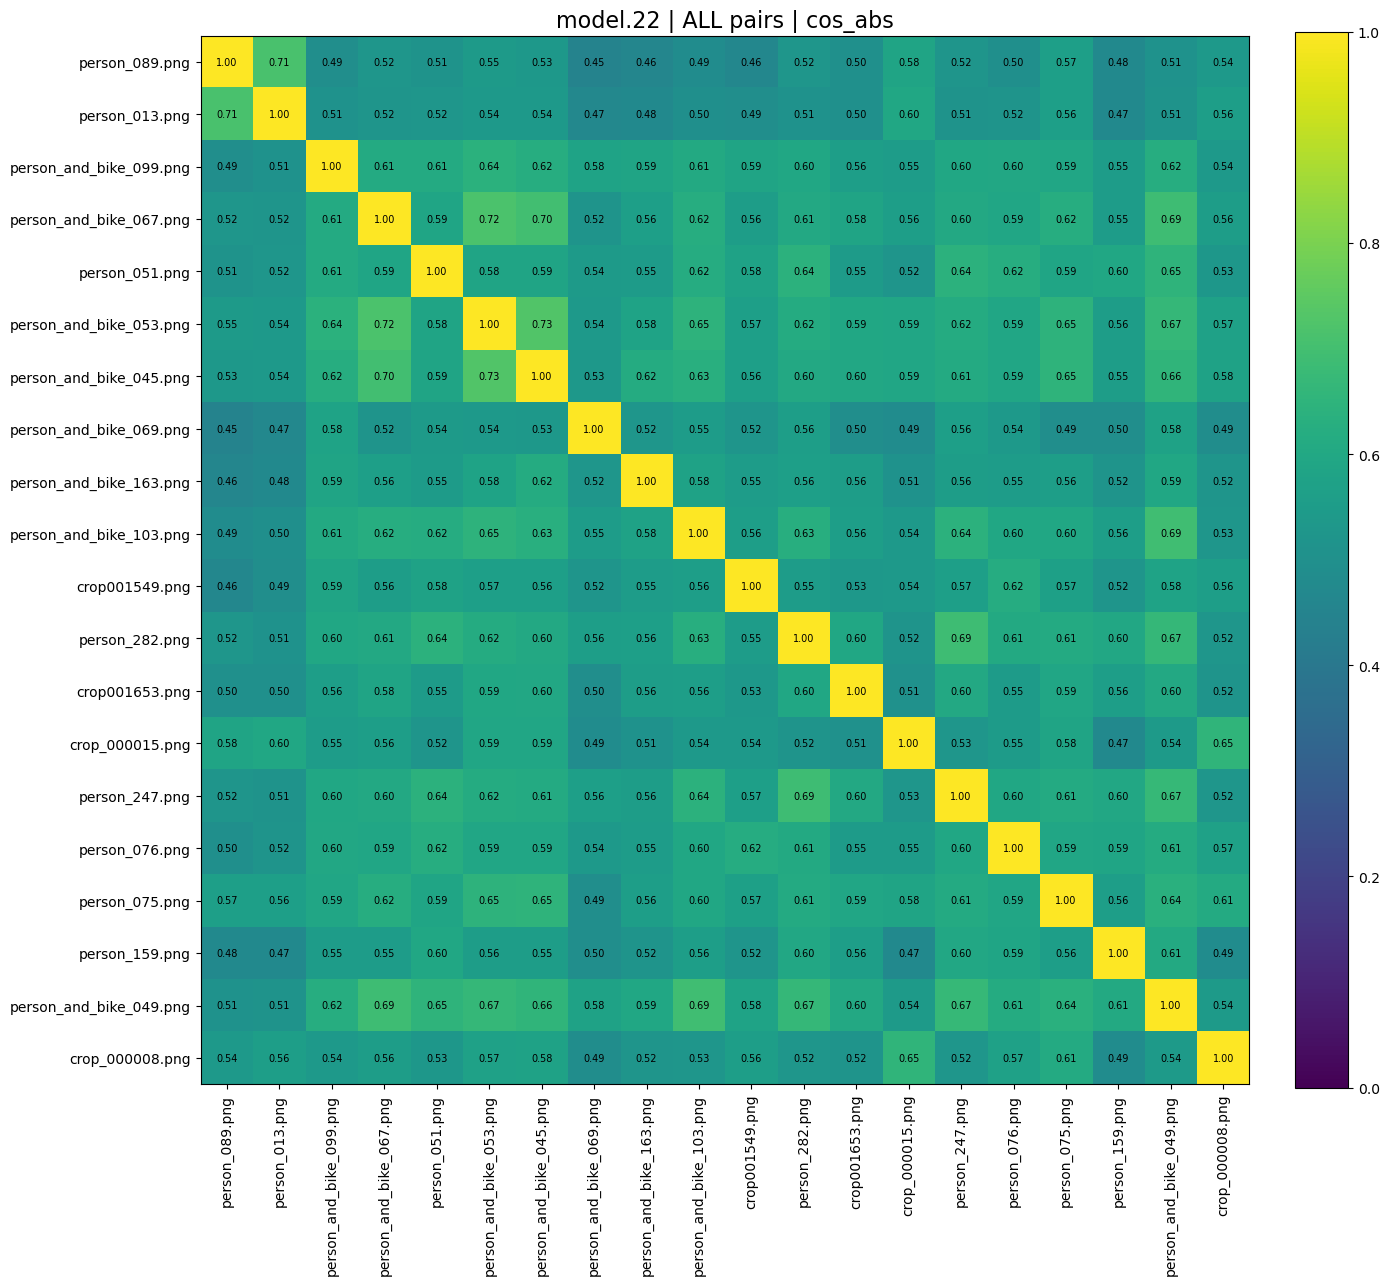

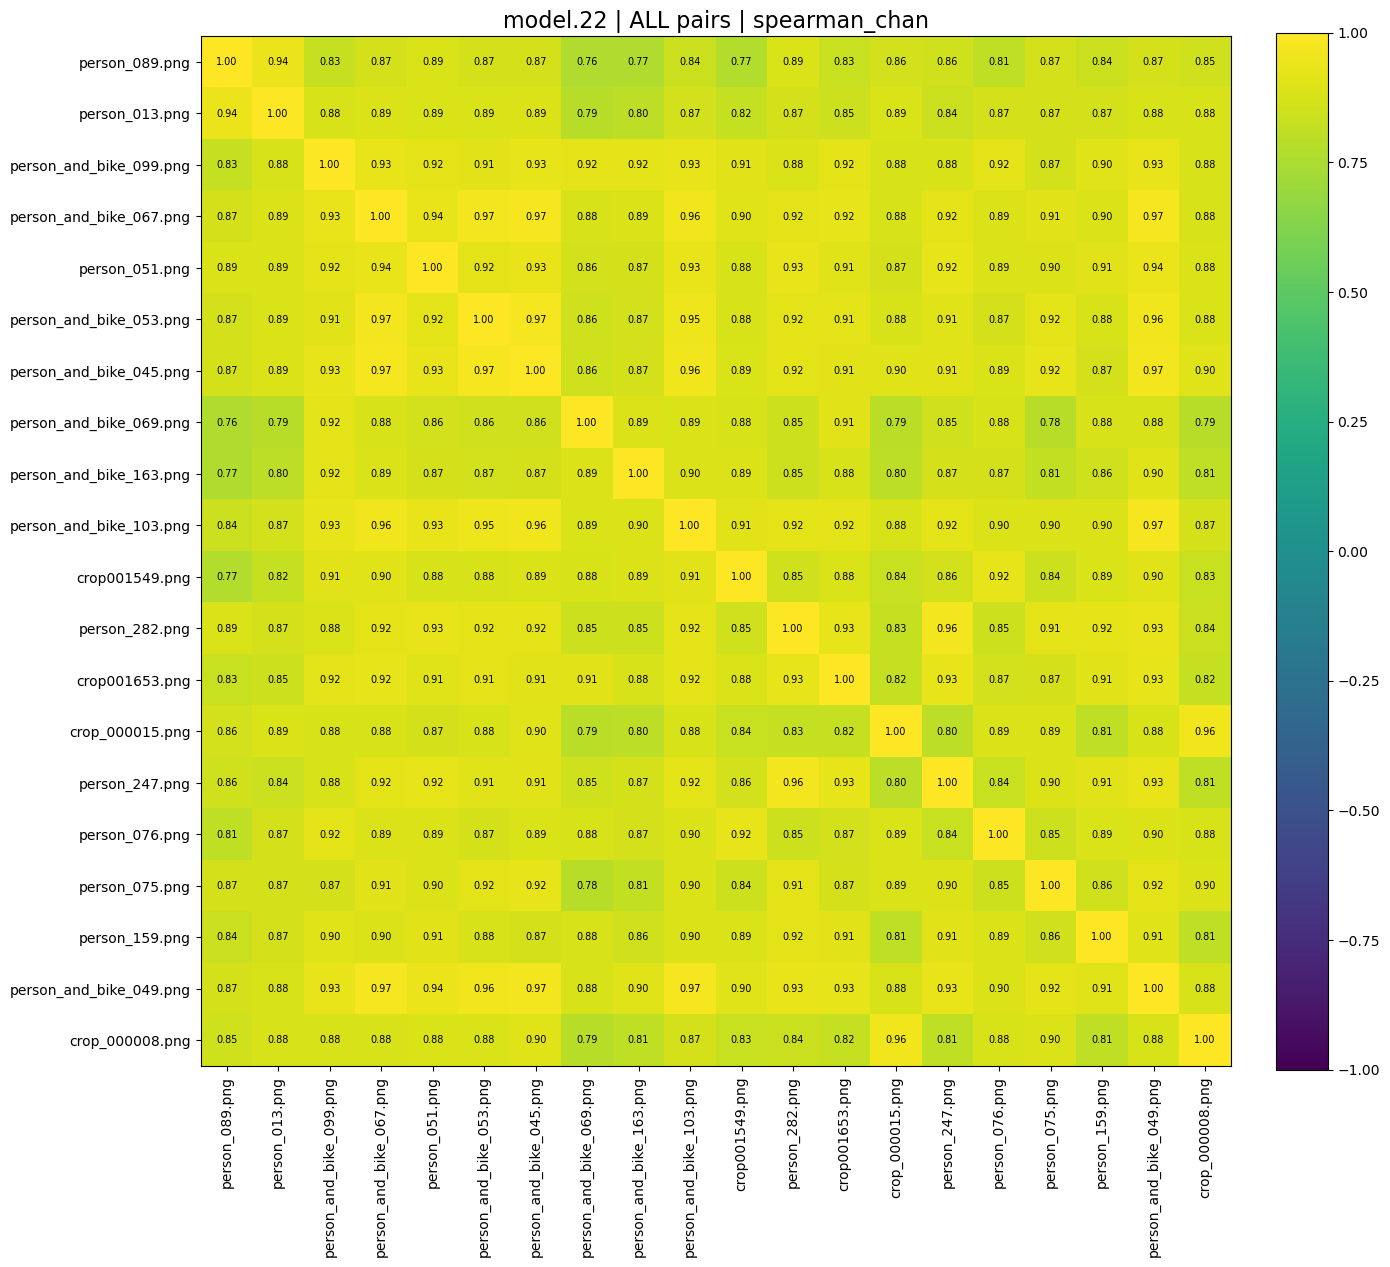

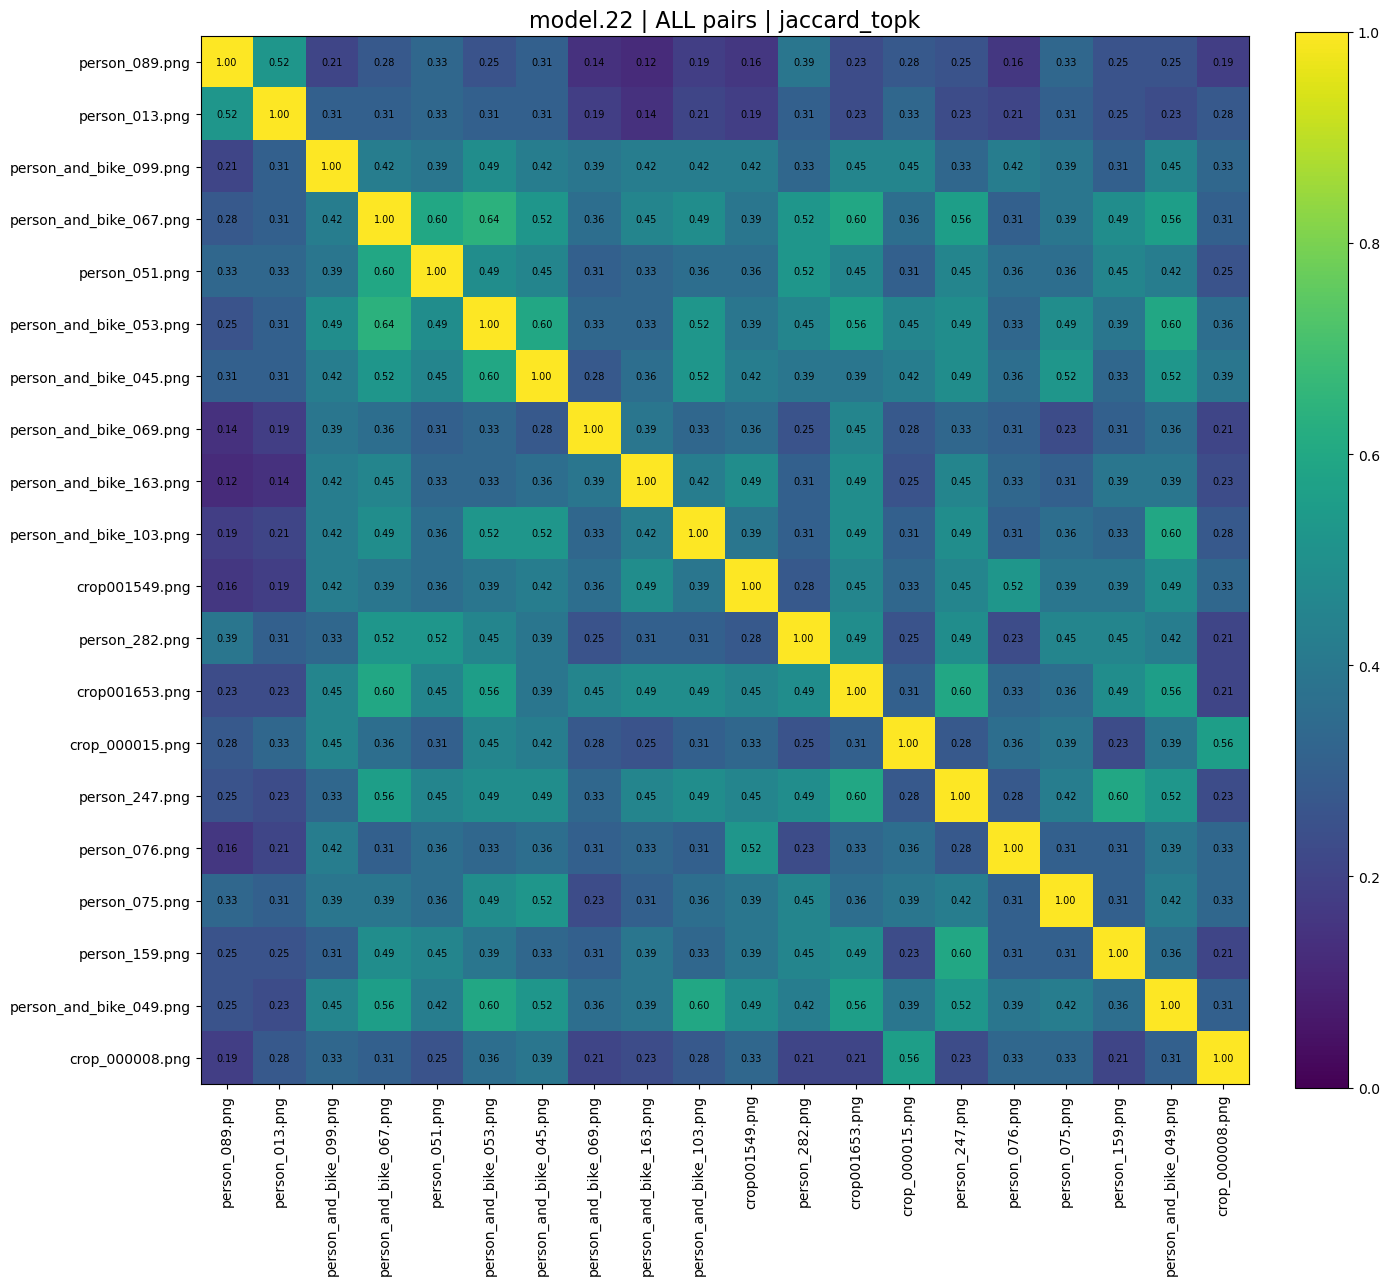

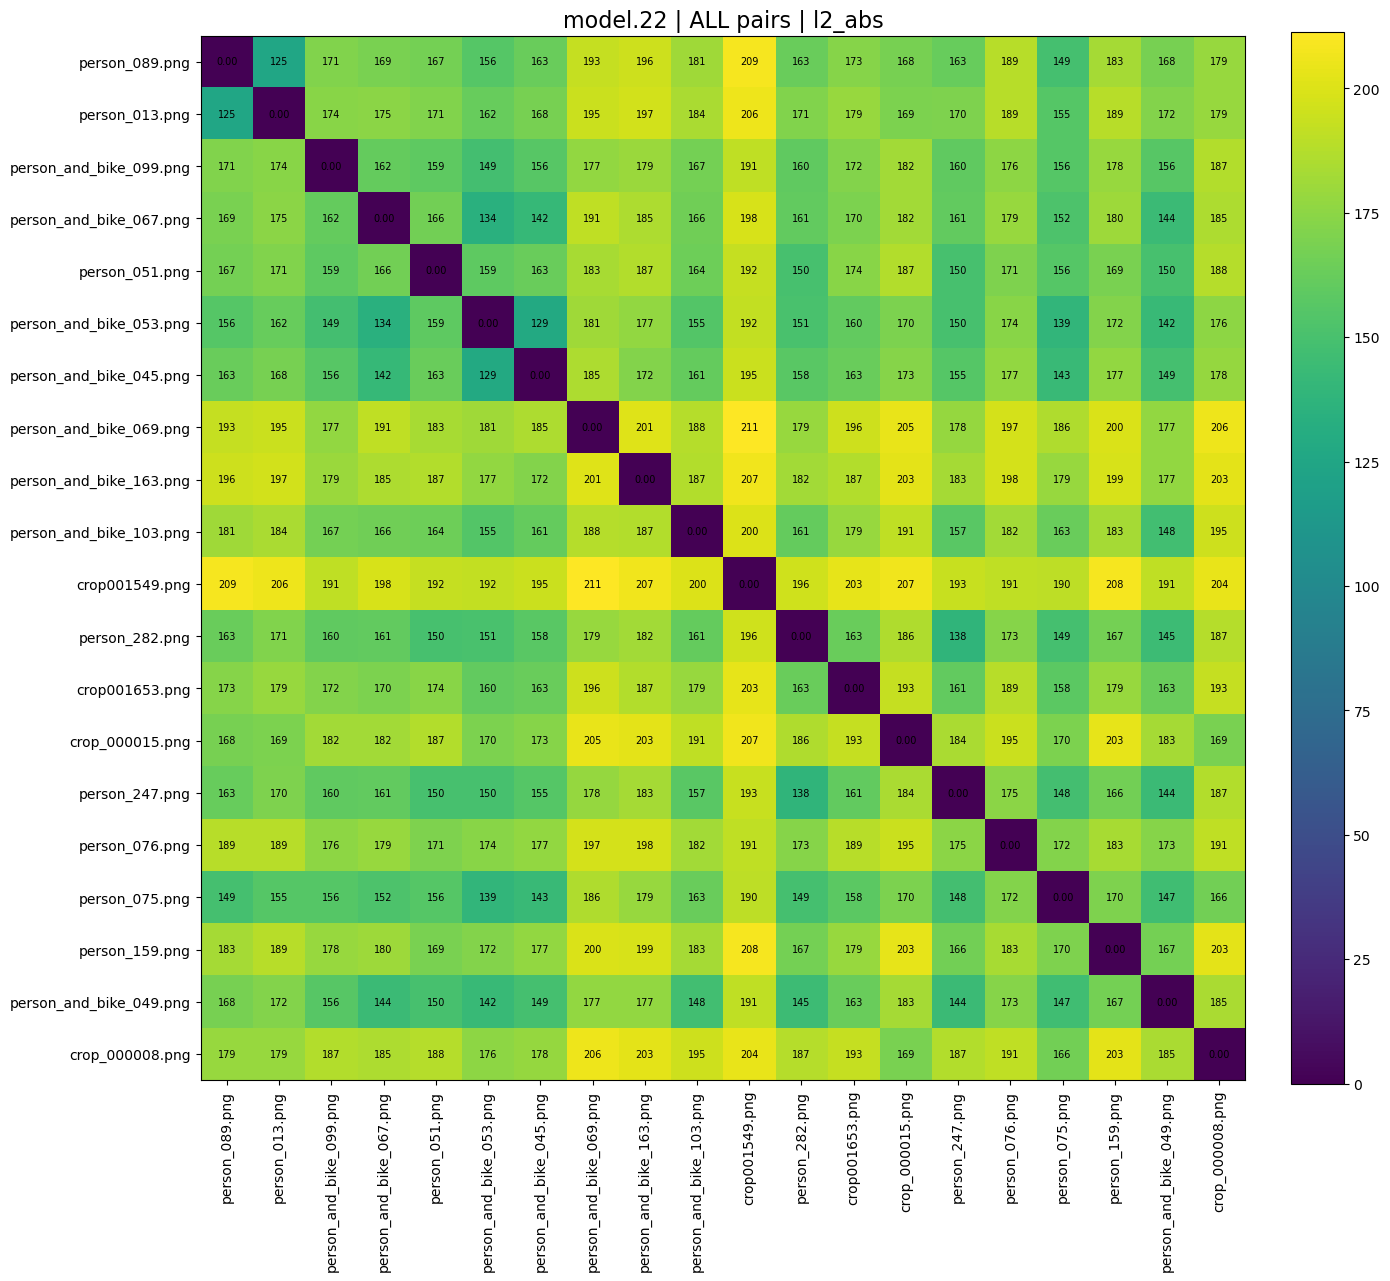


Group sizes: success=10 fail=10


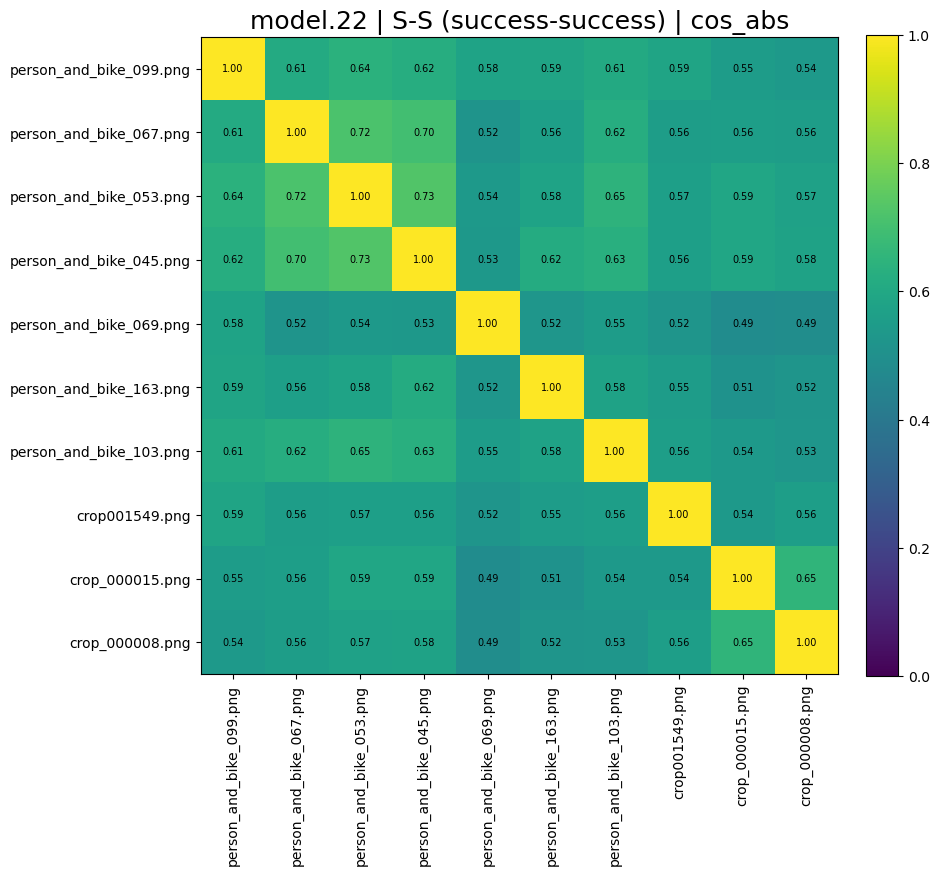

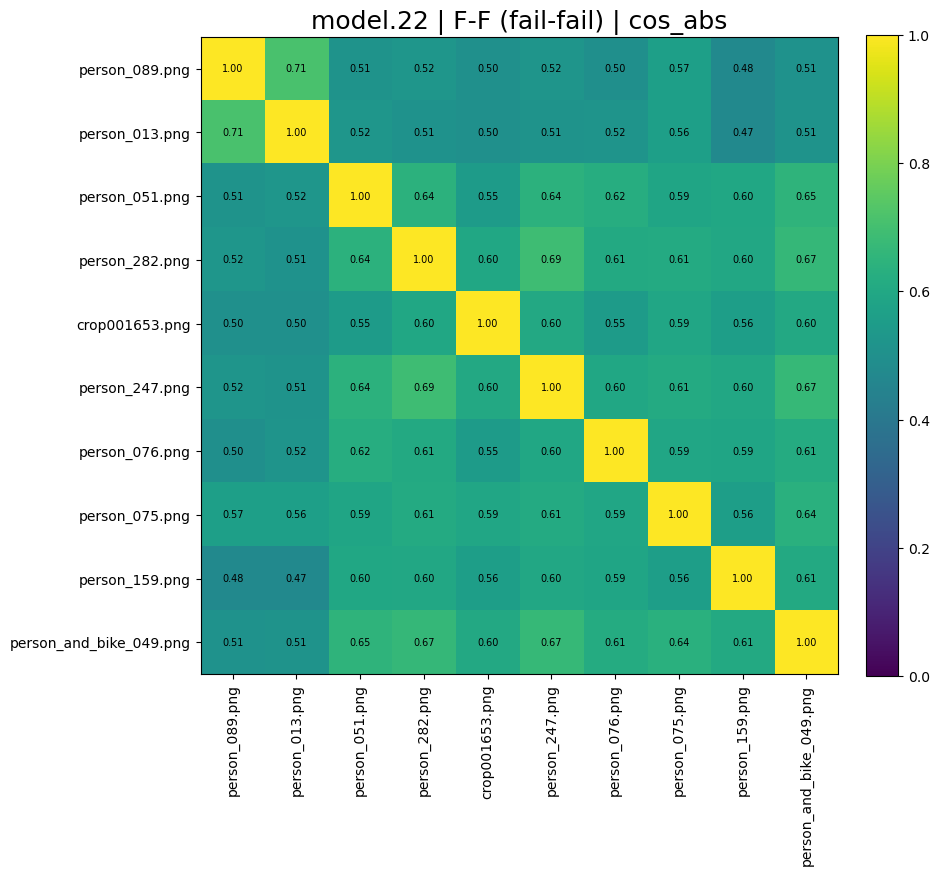

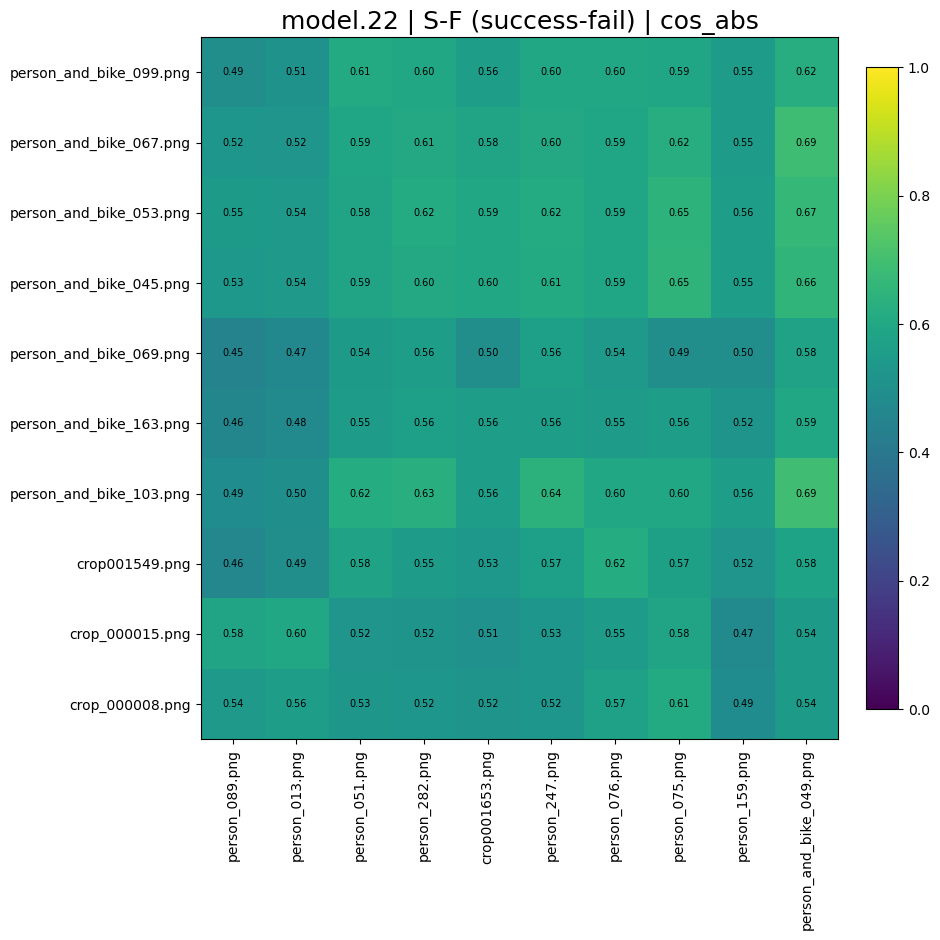

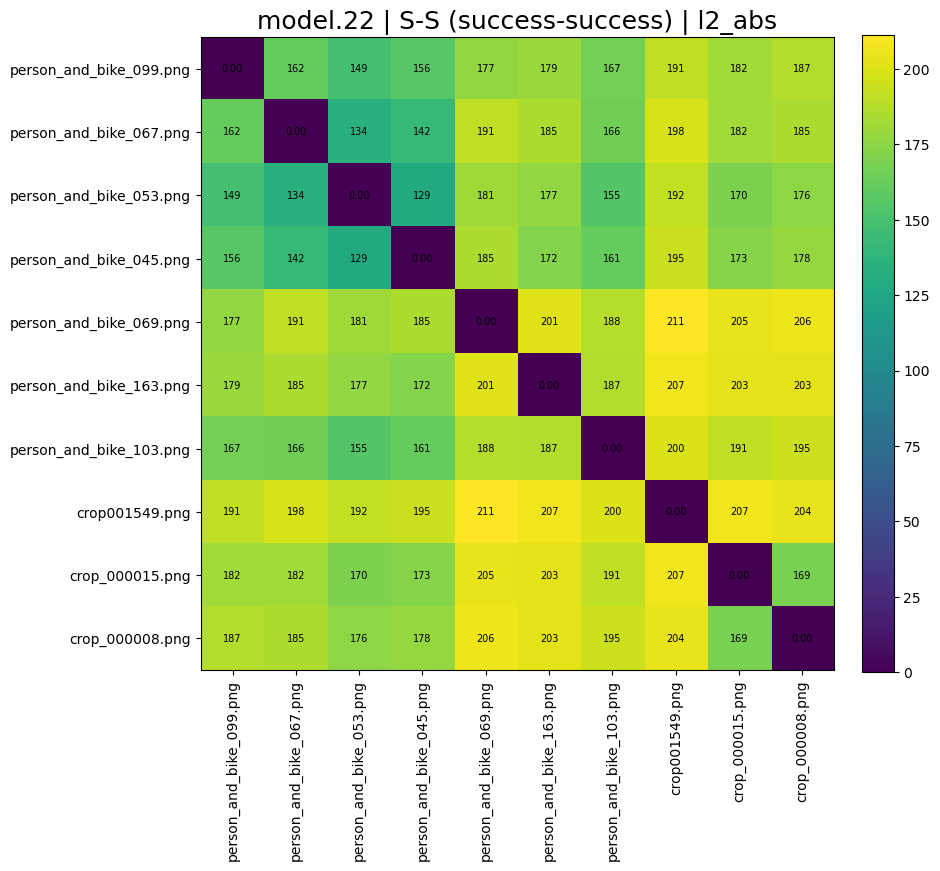

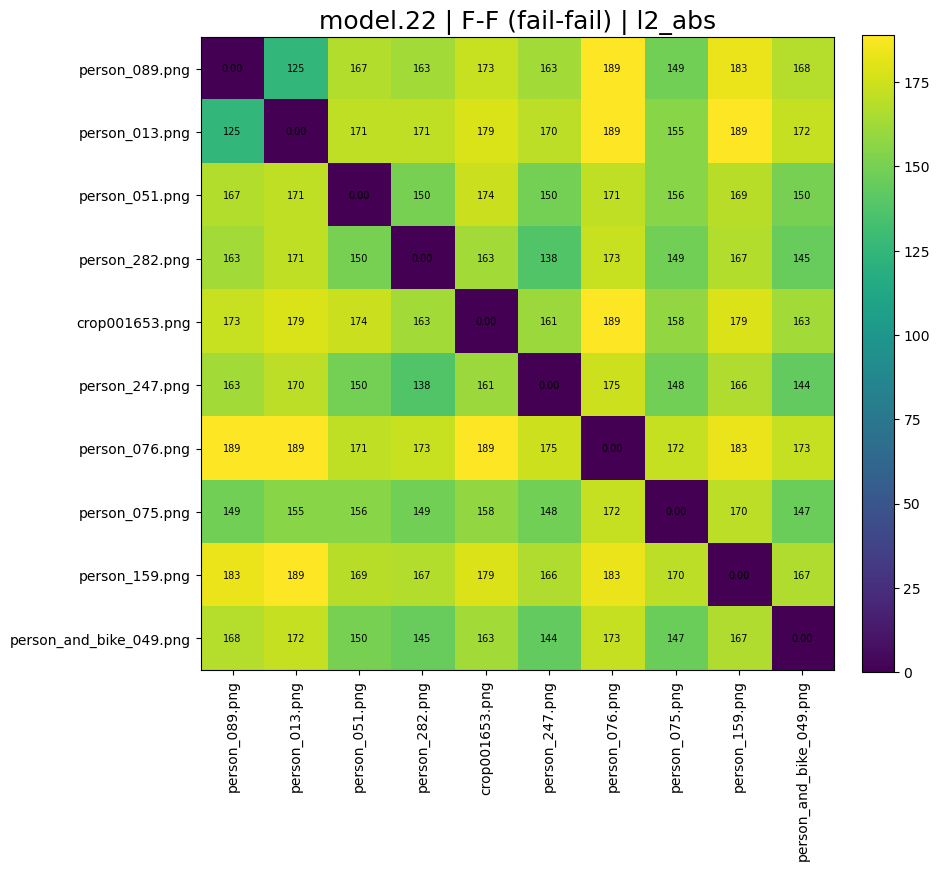

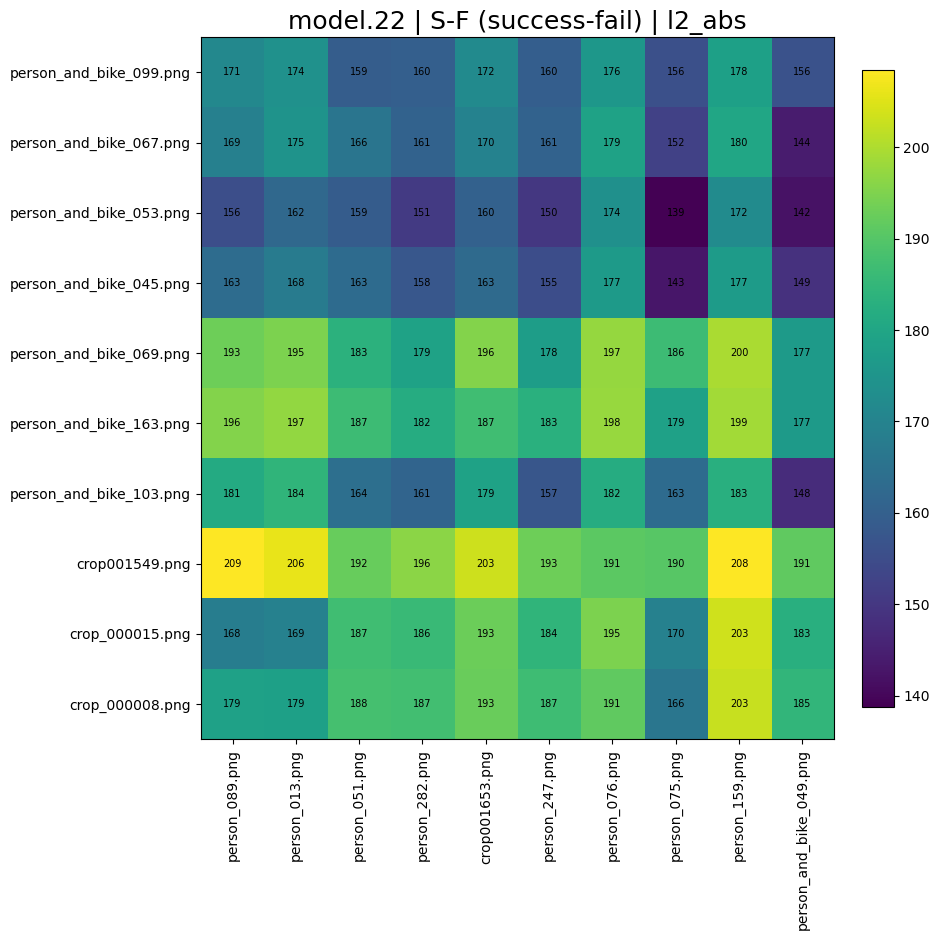

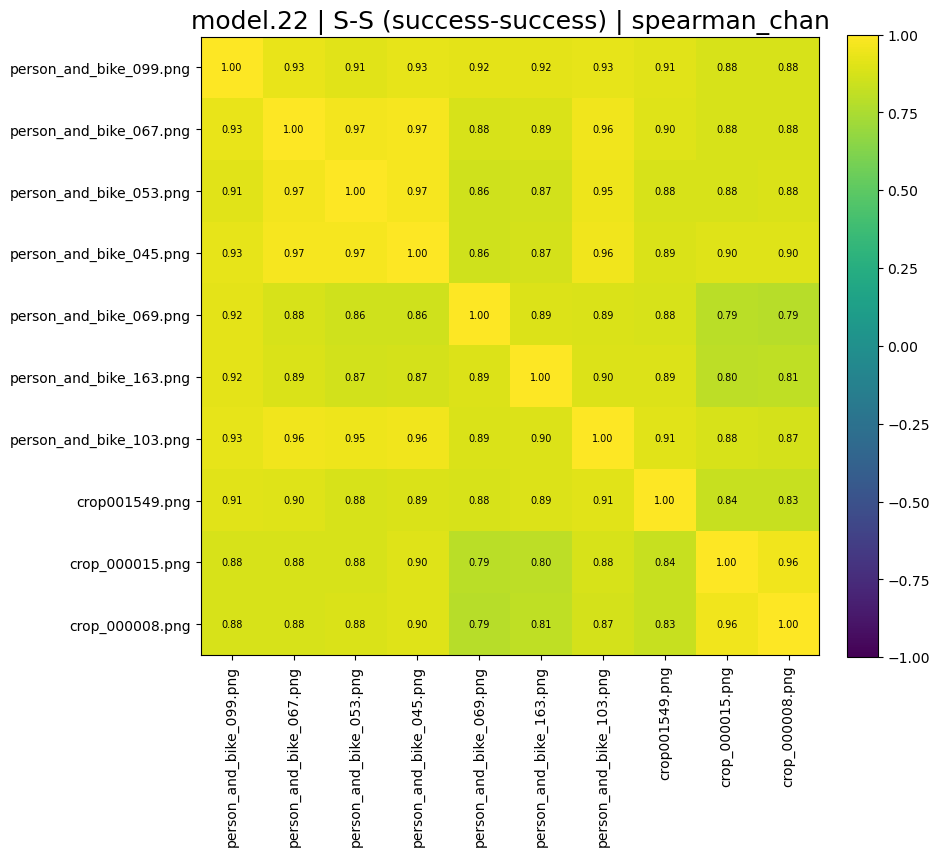

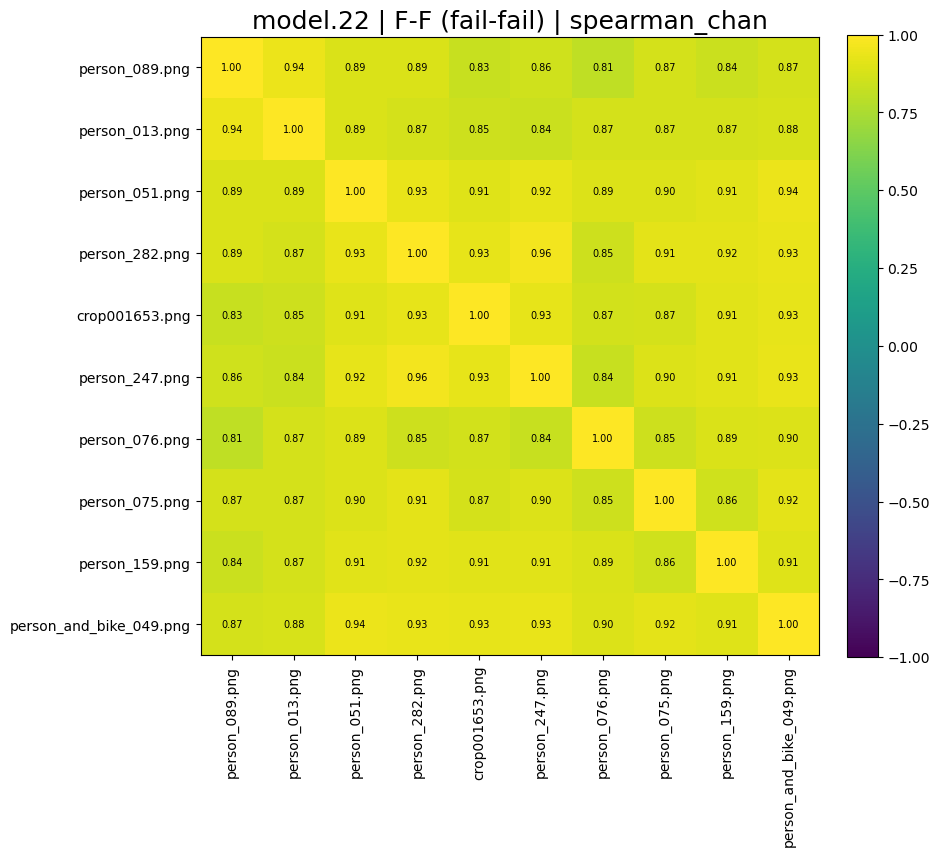

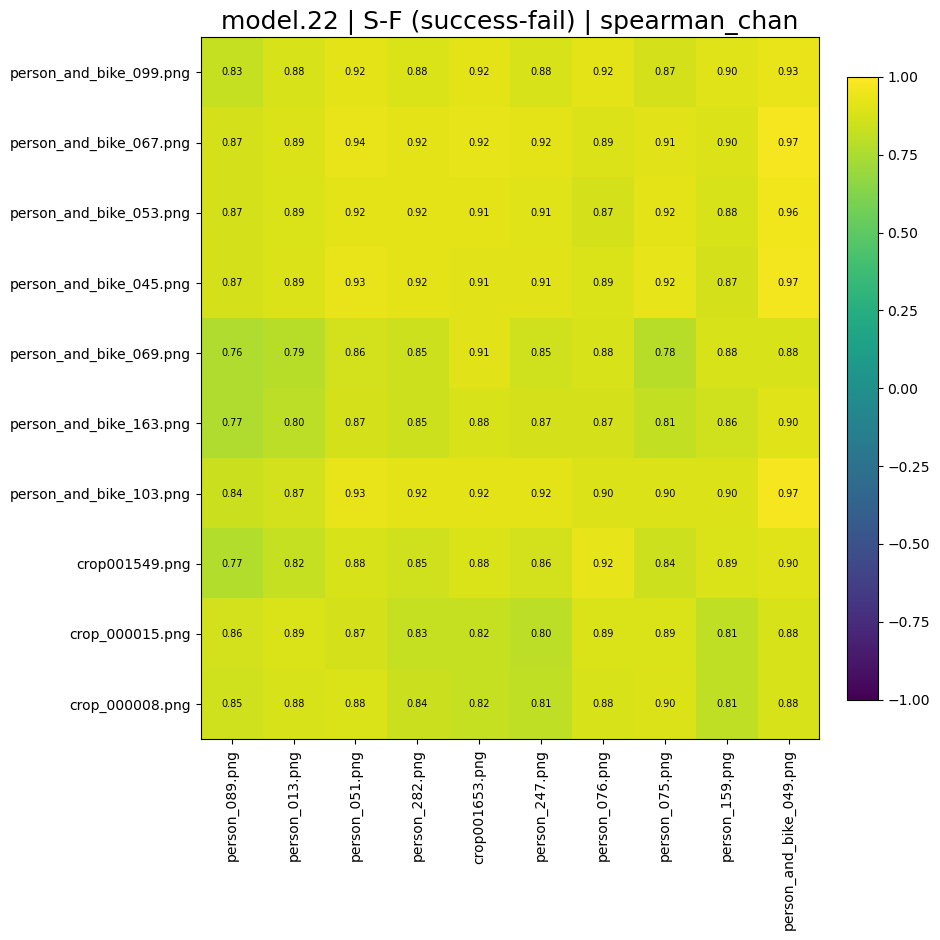

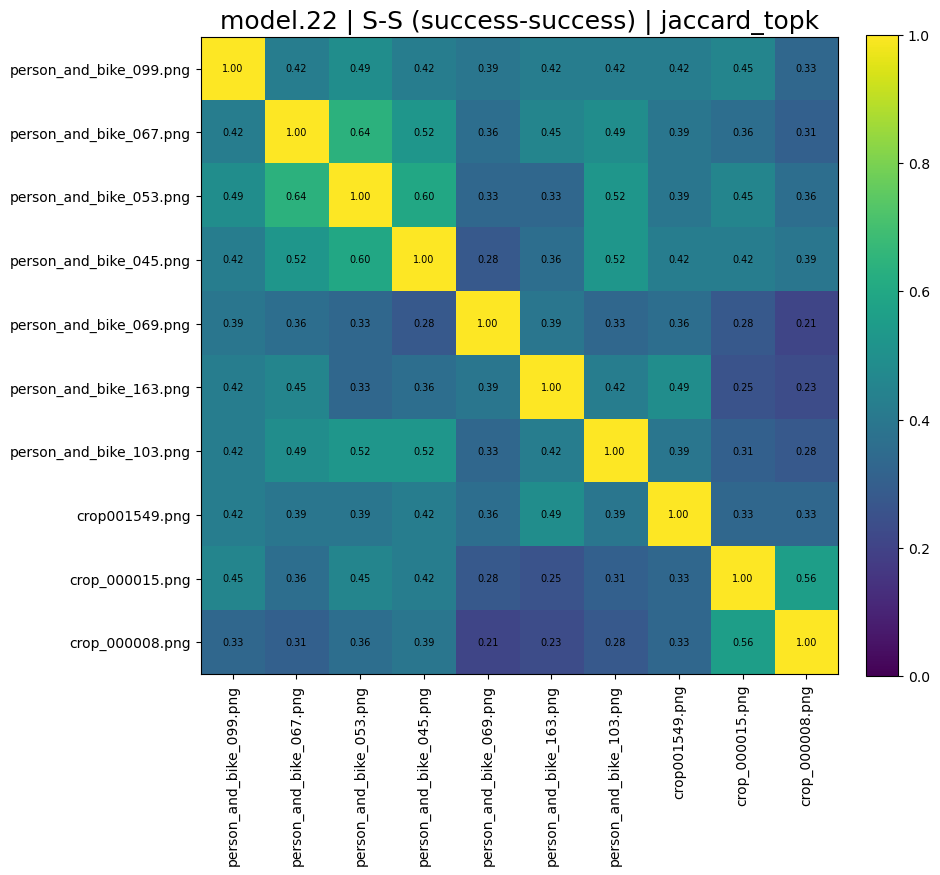

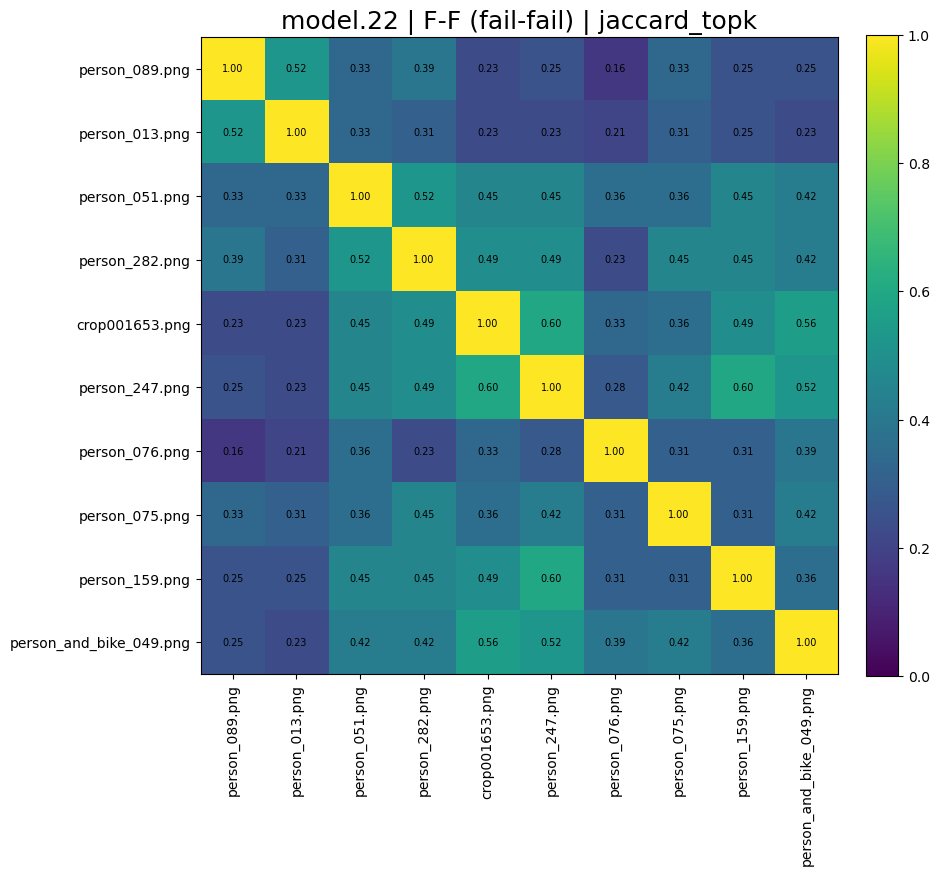

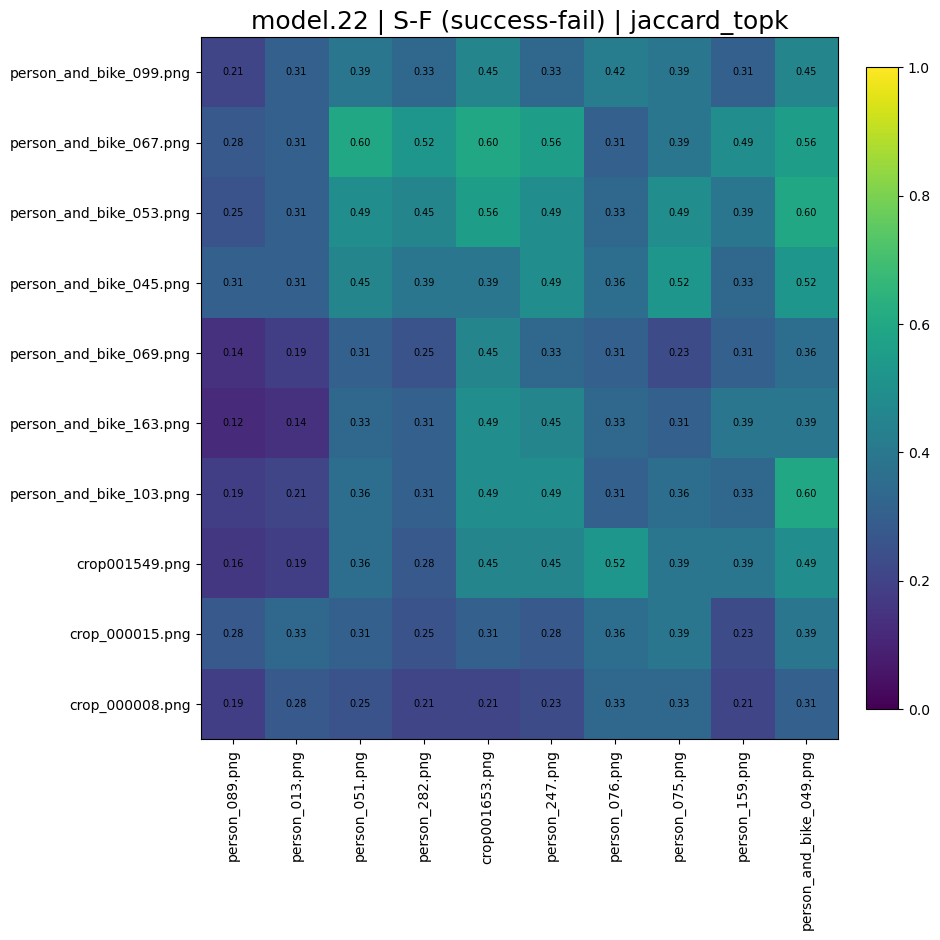


Metric: cos_abs
  S-S: n=45 mean=0.5768 std=0.0542 var=0.0029
  S-F: n=100 mean=0.5624 std=0.0507 var=0.0026
  F-F: n=45 mean=0.5772 std=0.0585 var=0.0034


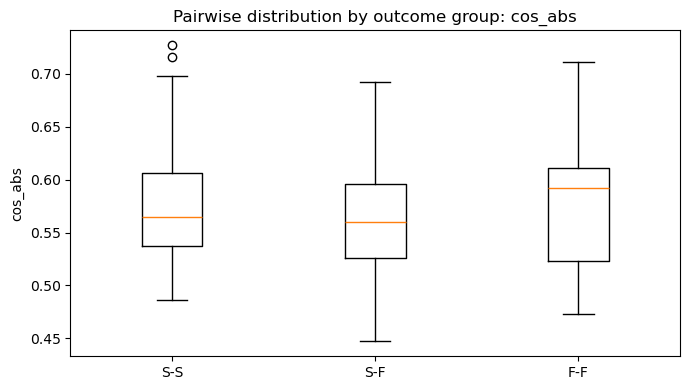


Metric: l2_abs
  S-S: n=45 mean=181.1343 std=19.8763 var=395.0655
  S-F: n=100 mean=176.4542 std=16.6163 var=276.1027
  F-F: n=45 mean=164.9738 std=14.4702 var=209.3855


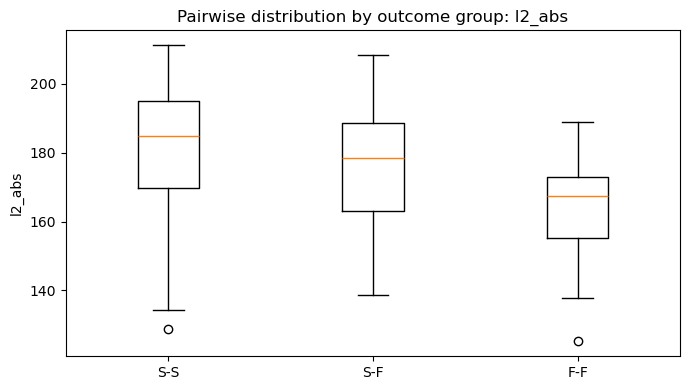


Metric: spearman_chan
  S-S: n=45 mean=0.8918 std=0.0458 var=0.0021
  S-F: n=100 mean=0.8786 std=0.0438 var=0.0019
  F-F: n=45 mean=0.8896 std=0.0352 var=0.0012


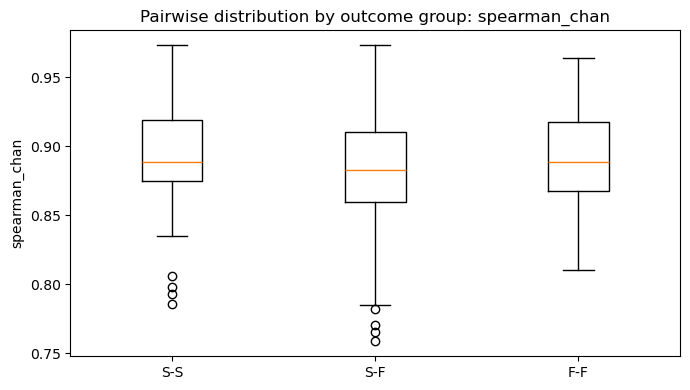


Metric: jaccard_topk
  S-S: n=45 mean=0.3974 std=0.0939 var=0.0088
  S-F: n=100 mean=0.3583 std=0.1148 var=0.0132
  F-F: n=45 mean=0.3706 std=0.1124 var=0.0126


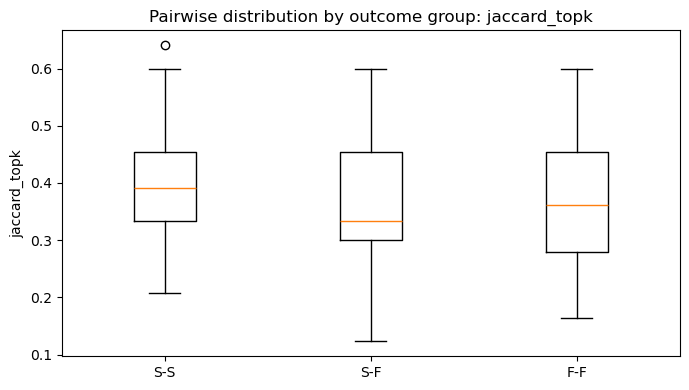

In [28]:
from itertools import combinations
from pathlib import Path

def _pair_type(si: bool, sj: bool) -> str:
    if si and sj:
        return "S-S"
    if (si and (not sj)) or ((not si) and sj):
        return "S-F"
    return "F-F"

def build_pairwise_matrices_for_layer(run_data, layer: str, topk: int):
    """
    Returns:
      labels: image names
      mats: metric -> NxN matrix (NaN if missing)
      vals_by_type: pairtype -> metric -> list[float]
      pairs_by_type: pairtype -> list[(i,j)]
    """
    N = len(run_data)
    labels = [Path(d["path"]).name for d in run_data]

    metrics = ["cos_abs", "l2_abs", "spearman_chan", "jaccard_topk"]
    mats = {k: np.full((N, N), np.nan, dtype=np.float64) for k in metrics}

    # diagonals
    for k in metrics:
        mats[k][np.arange(N), np.arange(N)] = 1.0
    mats["l2_abs"][np.arange(N), np.arange(N)] = 0.0

    vals_by_type = {
        "ALL": {k: [] for k in metrics},
        "S-S": {k: [] for k in metrics},
        "S-F": {k: [] for k in metrics},
        "F-F": {k: [] for k in metrics},
    }
    pairs_by_type = {"ALL": [], "S-S": [], "S-F": [], "F-F": []}

    for i, j in combinations(range(N), 2):
        di = run_data[i]["deltas"].get(layer, None)
        dj = run_data[j]["deltas"].get(layer, None)
        if di is None or dj is None:
            continue

        m = delta_similarity_metrics(di, dj, topk=topk)
        ptype = _pair_type(bool(run_data[i]["success"]), bool(run_data[j]["success"]))

        for k in metrics:
            v = float(m[k])
            mats[k][i, j] = v
            mats[k][j, i] = v
            vals_by_type["ALL"][k].append(v)
            vals_by_type[ptype][k].append(v)

        pairs_by_type["ALL"].append((i, j))
        pairs_by_type[ptype].append((i, j))

    return labels, mats, vals_by_type, pairs_by_type


def plot_heatmap_with_numbers(
    mat: np.ndarray,
    xlabels,
    ylabels,
    title: str,
    vmin=None,
    vmax=None,
    title_fontsize: int = 16,
    label_fontsize: int = 10,
    number_fontsize: int = 7,
    aspect: str = "equal",
):
    """Heatmap + numeric annotation. NaNs stay blank. Supports non-square matrices."""
    H, W = mat.shape
    # keep cells readable; grow with matrix size
    plt.figure(figsize=(0.45 * W + 5, 0.45 * H + 5))
    im = plt.imshow(mat, aspect=aspect, vmin=vmin, vmax=vmax)
    plt.title(title, fontsize=title_fontsize)
    plt.xticks(np.arange(W), xlabels, rotation=90, fontsize=label_fontsize)
    plt.yticks(np.arange(H), ylabels, fontsize=label_fontsize)

    for i in range(H):
        for j in range(W):
            v = mat[i, j]
            if np.isnan(v):
                continue
            txt = f"{v:.2f}" if abs(v) < 100 else f"{v:.0f}"
            plt.text(j, i, txt, ha="center", va="center", fontsize=number_fontsize)

    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


def plot_group_distributions(vals_by_type, metric: str):
    """Boxplot + mean/var/std for S-S/S-F/F-F."""
    groups = ["S-S", "S-F", "F-F"]
    data = [vals_by_type[g][metric] for g in groups]

    print(f"\nMetric: {metric}")
    for g in groups:
        s = summarize(vals_by_type[g][metric])
        std = float(np.sqrt(max(0.0, s["var"])))
        print(f"  {g}: n={len(vals_by_type[g][metric])} mean={s['mean']:.4f} std={std:.4f} var={s['var']:.4f}")

    plt.figure(figsize=(7, 4))
    plt.boxplot(data, tick_labels=groups, showfliers=True)
    plt.title(f"Pairwise distribution by outcome group: {metric}")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()


# ---- RUN (assumes single layer) ----
assert len(layer_names) == 1, f"Expected single layer, got {layer_names}"
layer = layer_names[0]

labels, mats, vals_by_type, pairs_by_type = build_pairwise_matrices_for_layer(
    run_data, layer=layer, topk=CFG.topk_channels
)

print(f"\nPairwise comparisons for layer: {layer} | N images = {len(labels)}")
print("Pairs:", {k: len(v) for k, v in pairs_by_type.items()})

# 1) Full NxN heatmaps
plot_heatmap_with_numbers(mats["cos_abs"], labels, labels, f"{layer} | ALL pairs | cos_abs", vmin=0.0, vmax=1.0)
plot_heatmap_with_numbers(mats["spearman_chan"], labels, labels, f"{layer} | ALL pairs | spearman_chan", vmin=-1.0, vmax=1.0)
plot_heatmap_with_numbers(mats["jaccard_topk"], labels, labels, f"{layer} | ALL pairs | jaccard_topk", vmin=0.0, vmax=1.0)
plot_heatmap_with_numbers(mats["l2_abs"], labels, labels, f"{layer} | ALL pairs | l2_abs")

# 2) Group heatmaps (compact views)
metrics = ["cos_abs", "l2_abs", "spearman_chan", "jaccard_topk"]

succ_idx = [i for i, d in enumerate(run_data) if bool(d["success"])]
fail_idx = [i for i, d in enumerate(run_data) if not bool(d["success"])]

succ_labels = [labels[i] for i in succ_idx]
fail_labels = [labels[i] for i in fail_idx]

print(f"\nGroup sizes: success={len(succ_idx)} fail={len(fail_idx)}")

for k in metrics:
    # S-S: success x success
    ss = mats[k][np.ix_(succ_idx, succ_idx)]
    title = f"{layer} | S-S (success-success) | {k}"
    if k in {"cos_abs", "jaccard_topk"}:
        plot_heatmap_with_numbers(ss, succ_labels, succ_labels, title, vmin=0.0, vmax=1.0, title_fontsize=18)
    elif k == "spearman_chan":
        plot_heatmap_with_numbers(ss, succ_labels, succ_labels, title, vmin=-1.0, vmax=1.0, title_fontsize=18)
    else:
        plot_heatmap_with_numbers(ss, succ_labels, succ_labels, title, title_fontsize=18)

    # F-F: fail x fail
    ff = mats[k][np.ix_(fail_idx, fail_idx)]
    title = f"{layer} | F-F (fail-fail) | {k}"
    if k in {"cos_abs", "jaccard_topk"}:
        plot_heatmap_with_numbers(ff, fail_labels, fail_labels, title, vmin=0.0, vmax=1.0, title_fontsize=18)
    elif k == "spearman_chan":
        plot_heatmap_with_numbers(ff, fail_labels, fail_labels, title, vmin=-1.0, vmax=1.0, title_fontsize=18)
    else:
        plot_heatmap_with_numbers(ff, fail_labels, fail_labels, title, title_fontsize=18)

    # S-F: success x fail (rectangular)
    sf = mats[k][np.ix_(succ_idx, fail_idx)]
    title = f"{layer} | S-F (success-fail) | {k}"
    if k in {"cos_abs", "jaccard_topk"}:
        plot_heatmap_with_numbers(sf, fail_labels, succ_labels, title, vmin=0.0, vmax=1.0, title_fontsize=18, aspect="auto")
    elif k == "spearman_chan":
        plot_heatmap_with_numbers(sf, fail_labels, succ_labels, title, vmin=-1.0, vmax=1.0, title_fontsize=18, aspect="auto")
    else:
        plot_heatmap_with_numbers(sf, fail_labels, succ_labels, title, title_fontsize=18, aspect="auto")

# 3) Distribution comparisons
for k in metrics:
    plot_group_distributions(vals_by_type, metric=k)

In [29]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path


def _roi_mask_on_grid(h: int, w: int, stride: float, imgsz: int, bbox_xyxy: Tuple[float, float, float, float], device, dtype):
    """Create (1,h,w) ROI mask for a bbox in input pixel coords.

    We mark a cell as inside ROI if its center lies within bbox. Mask is constant w.r.t. network (OK).
    """
    x1, y1, x2, y2 = bbox_xyxy
    ys = (torch.arange(h, device=device, dtype=dtype) + 0.5) * float(stride)
    xs = (torch.arange(w, device=device, dtype=dtype) + 0.5) * float(stride)
    yy, xx = torch.meshgrid(ys, xs, indexing="ij")

    m = (xx >= float(x1)) & (xx <= float(x2)) & (yy >= float(y1)) & (yy <= float(y2))
    mask = m.to(dtype=dtype)

    # If bbox is tiny on this level, fallback to a single closest cell to bbox center
    if float(mask.sum().item()) < 1.0:
        cx = 0.5 * (float(x1) + float(x2))
        cy = 0.5 * (float(y1) + float(y2))
        d2 = (xx - cx) ** 2 + (yy - cy) ** 2
        ij = torch.argmin(d2)
        mask = torch.zeros_like(mask)
        mask.view(-1)[ij] = 1.0

    # Normalize to sum=1 for stable scale
    mask = mask / (mask.sum() + 1e-12)
    return mask.unsqueeze(0)  # (1,h,w)


def center_person_surrogate_scalar_bbox(
    model_torch: nn.Module,
    x_bchw: torch.Tensor,
    target_class_id: int,
    imgsz: int,
    bbox_xyxy: Tuple[float, float, float, float],
) -> Tuple[torch.Tensor, Dict[str, Any]]:
    """Differentiable target scalar: mean person probability *inside the chosen bbox* (selected after NMS).

    We bypass Detect._inference() (which may create inference-mode tensors) by forcing Detect head into training path.
    """
    detect = get_module_by_name(model_torch, "model.23")

    # Keep backbone/neck eval for stability, but Detect train to bypass _inference()
    was_detect_training = bool(detect.training)
    detect.train()
    try:
        out = model_torch(x_bchw)
    finally:
        if not was_detect_training:
            detect.eval()

    pred_levels = out
    if isinstance(out, (tuple, list)) and len(out) == 2 and isinstance(out[0], torch.Tensor):
        # some builds return (pred, x)
        pred_levels = out[1]

    if not isinstance(pred_levels, (list, tuple)) or len(pred_levels) == 0:
        raise RuntimeError(f"Unexpected Detect output type: {type(pred_levels)}")

    reg_max = int(getattr(detect, "reg_max", 16))
    nc = int(getattr(detect, "nc", 80))

    strides = getattr(detect, "strides", None)
    if strides is None:
        strides = getattr(detect, "stride", None)
    if strides is None:
        strides = [8, 16, 32][: len(pred_levels)]

    if isinstance(strides, torch.Tensor):
        strides_list = [float(s) for s in strides.flatten().tolist()]
    else:
        strides_list = [float(s) for s in list(strides)]

    scalars = []
    level_debug = []

    for li, t in enumerate(pred_levels):
        if not (isinstance(t, torch.Tensor) and t.ndim == 4):
            continue
        B, C, h, w = t.shape
        need = reg_max * 4 + nc
        if C < need:
            raise RuntimeError(f"Level {li}: unexpected channels C={C}, need >= {need} (reg_max*4+nc)")

        cls_logits = t[:, reg_max * 4: reg_max * 4 + nc, :, :]  # (B,nc,h,w)
        p = cls_logits.sigmoid()[:, int(target_class_id), :, :]  # (B,h,w)

        # Robust stride estimate from feature map resolution.
        # Avoids bugs when pred_levels order doesn't match detect.strides order.
        stride_h = float(imgsz) / float(h)
        stride_w = float(imgsz) / float(w)
        stride = 0.5 * (stride_h + stride_w)
        roi = _roi_mask_on_grid(h, w, stride=stride, imgsz=imgsz, bbox_xyxy=bbox_xyxy, device=p.device, dtype=p.dtype)  # (1,h,w)

        s = (p * roi).sum(dim=(1, 2))  # (B,)
        scalars.append(s)

        level_debug.append({"level": li, "shape": (int(B), int(C), int(h), int(w)), "stride": float(stride), "roi_sum": float(roi.sum().detach().cpu().item())})

    if len(scalars) == 0:
        raise RuntimeError("No valid prediction tensors from Detect head.")

    scalar = torch.stack(scalars, dim=0).mean(dim=0).mean()  # scalar
    info = {
        "levels": level_debug,
        "reg_max": reg_max,
        "nc": nc,
        "target_class_id": int(target_class_id),
        "bbox_xyxy": [float(x) for x in bbox_xyxy],
    }
    return scalar, info


def layer_grad_and_act_for_bbox_target(
    model_torch: nn.Module,
    x_bchw: torch.Tensor,
    target_layer_name: str,
    target_class_id: int,
    imgsz: int,
    bbox_xyxy: Tuple[float, float, float, float],
) -> Tuple[torch.Tensor, torch.Tensor, float]:
    """Return (A, G, target_scalar) for the bbox-conditioned person target.

    A, G are returned on CPU float32 with shape (1,C,h,w).
    """
    device = next(model_torch.parameters()).device
    dtype = next(model_torch.parameters()).dtype

    x = x_bchw.to(device=device, dtype=dtype)
    x.requires_grad_(True)

    layer = get_module_by_name(model_torch, target_layer_name)

    buf: Dict[str, torch.Tensor] = {}

    def _fwd_hook(_m, _inp, out):
        if isinstance(out, (list, tuple)):
            for o in out:
                if isinstance(o, torch.Tensor):
                    out = o
                    break
        if isinstance(out, torch.Tensor) and out.ndim == 4:
            buf["A"] = out

    def _bwd_hook(_m, _gin, gout):
        g = gout[0]
        if isinstance(g, torch.Tensor) and g.ndim == 4:
            buf["G"] = g

    h1 = layer.register_forward_hook(_fwd_hook)
    h2 = layer.register_full_backward_hook(_bwd_hook)

    try:
        model_torch.zero_grad(set_to_none=True)
        model_torch.eval()

        target, _tinfo = center_person_surrogate_scalar_bbox(
            model_torch,
            x,
            target_class_id=int(target_class_id),
            imgsz=int(imgsz),
            bbox_xyxy=bbox_xyxy,
        )
        target.backward()

        if "A" not in buf or "G" not in buf:
            raise RuntimeError("Failed to capture activation/grad for the target layer.")

        A = buf["A"].detach().to(device="cpu", dtype=torch.float32)
        G = buf["G"].detach().to(device="cpu", dtype=torch.float32)
        return A, G, float(target.detach().cpu().item())

    finally:
        h1.remove()
        h2.remove()
        x.requires_grad_(False)


def _normalize_2d(m: torch.Tensor) -> torch.Tensor:
    """Normalize (1,1,h,w) or (h,w) to [0,1]."""
    if m.ndim == 2:
        m = m.unsqueeze(0).unsqueeze(0)
    elif m.ndim == 4:
        pass
    else:
        raise ValueError(f"Unexpected ndim for normalize: {m.ndim}")

    m = m - m.amin(dim=(2, 3), keepdim=True)
    m = m / m.amax(dim=(2, 3), keepdim=True).clamp(min=1e-12)
    return m


def gradcam_raw_20(A_bchw: torch.Tensor, G_bchw: torch.Tensor) -> torch.Tensor:
    """Return Grad-CAM map on the layer grid as (1,1,h,w) in [0,1]."""
    # A,G: (1,C,h,w)
    w = G_bchw.mean(dim=(2, 3), keepdim=True)  # (1,C,1,1)
    cam = (w * A_bchw).sum(dim=1, keepdim=True)  # (1,1,h,w)
    cam = F.relu(cam)
    cam = _normalize_2d(cam)
    return cam


def grad_energy_raw_20(G_bchw: torch.Tensor) -> torch.Tensor:
    """Return |grad| energy map on the layer grid as (1,1,h,w) in [0,1]."""
    m = G_bchw.abs().sum(dim=1, keepdim=True)  # (1,1,h,w)
    m = _normalize_2d(m)
    return m


def delta_energy_raw_20(delta_bchw: torch.Tensor) -> torch.Tensor:
    """Return |Δ| energy map on the layer grid as (1,1,h,w) in [0,1]."""
    m = delta_bchw.abs().sum(dim=1, keepdim=True)  # (1,1,h,w)
    m = _normalize_2d(m)
    return m


def upsample_map(m_11hw: torch.Tensor, imgsz: int, mode: str) -> np.ndarray:
    """Upsample (1,1,h,w) -> (imgsz,imgsz) with mode in {'nearest','bilinear'} and return np float32."""
    if mode == "nearest":
        up = F.interpolate(m_11hw, size=(imgsz, imgsz), mode="nearest")
    elif mode == "bilinear":
        up = F.interpolate(m_11hw, size=(imgsz, imgsz), mode="bilinear", align_corners=False)
    else:
        raise ValueError(f"Unknown mode={mode}")
    return up[0, 0].detach().cpu().numpy().astype(np.float32)


def show_raw_overlays_side_by_side(
    pil_img,
    cam_raw_11hw: torch.Tensor,
    grad_raw_11hw: torch.Tensor,
    delta_raw_11hw: torch.Tensor,
    title: str = "",
    imgsz: int = 640,
):
    """Unsmooth (nearest) overlays side-by-side: Image | Grad-CAM | |∂y/∂A| | |ΔA|."""
    img = np.asarray(pil_img.convert("RGB"))

    def _to_heat(raw_11hw: torch.Tensor) -> np.ndarray:
        raw = raw_11hw.detach().to(device="cpu", dtype=torch.float32)
        heat = F.interpolate(raw, size=(imgsz, imgsz), mode="nearest")[0, 0].numpy()
        return heat

    cam_h = _to_heat(cam_raw_11hw)
    grad_h = _to_heat(grad_raw_11hw)
    delta_h = _to_heat(delta_raw_11hw)

    plt.figure(figsize=(22, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(img)
    plt.imshow(cam_h, alpha=0.45)
    plt.title("Grad-CAM | raw 20×20 (nearest)")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(img)
    plt.imshow(delta_h, alpha=0.45)
    plt.title("|ΔA| energy | raw 20×20 (nearest)")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(img)
    plt.imshow(grad_h, alpha=0.45)
    plt.title("|∂y/∂A| energy | raw 20×20 (nearest)")
    plt.axis("off")

    if title:
        plt.suptitle(title)

    plt.tight_layout()
    plt.show()

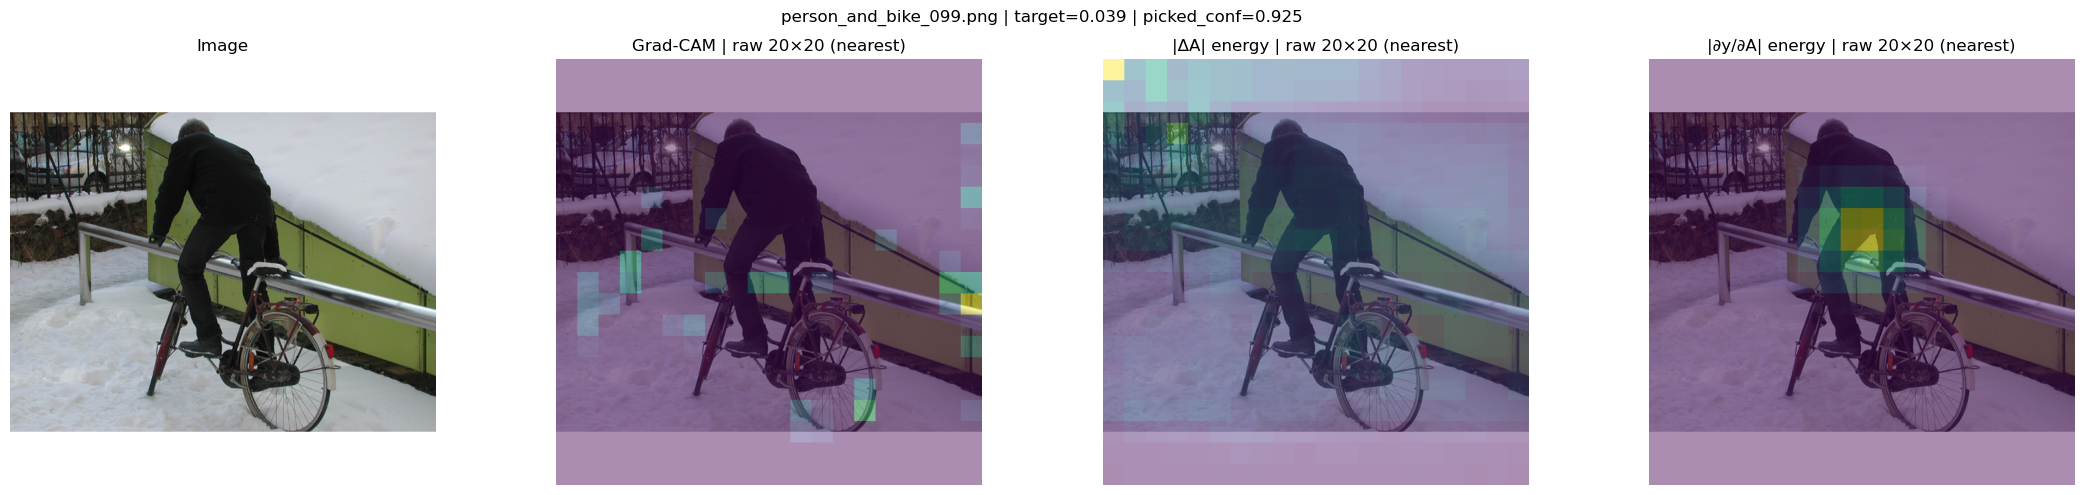

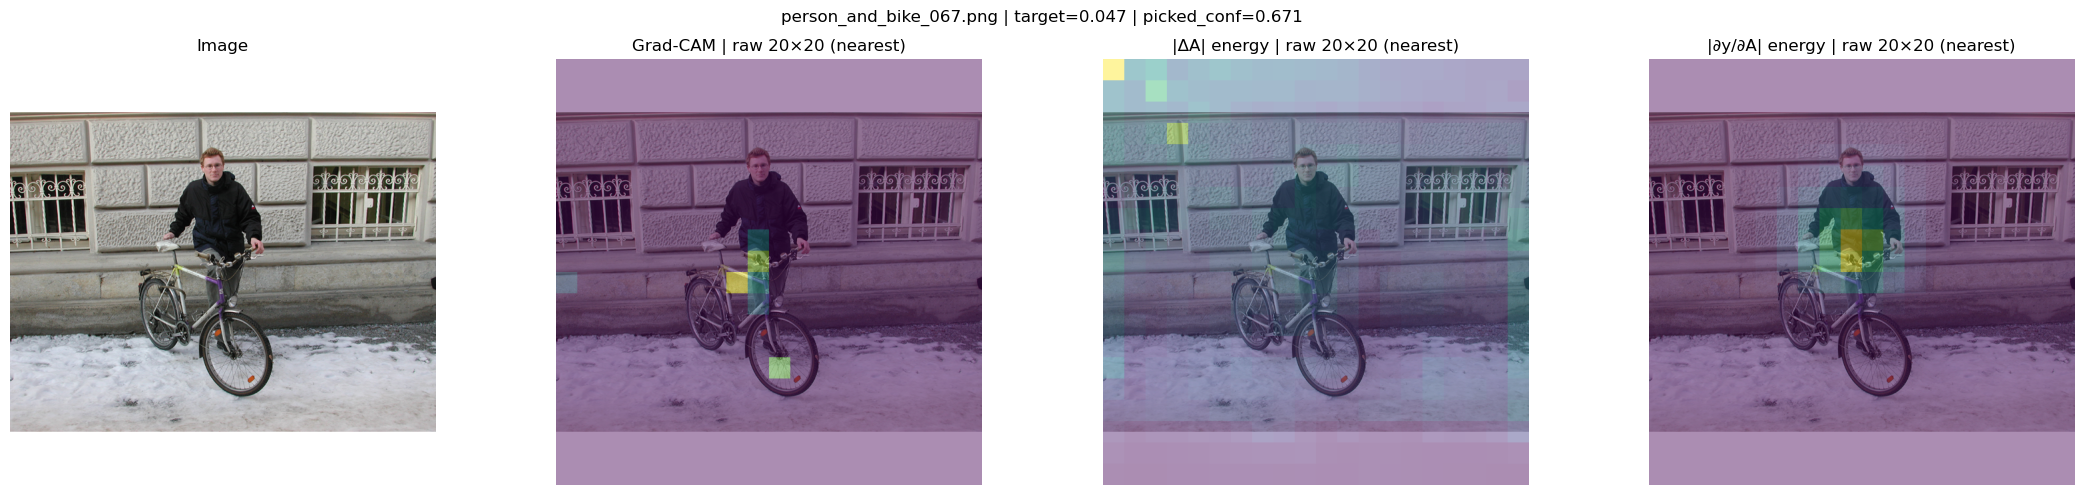

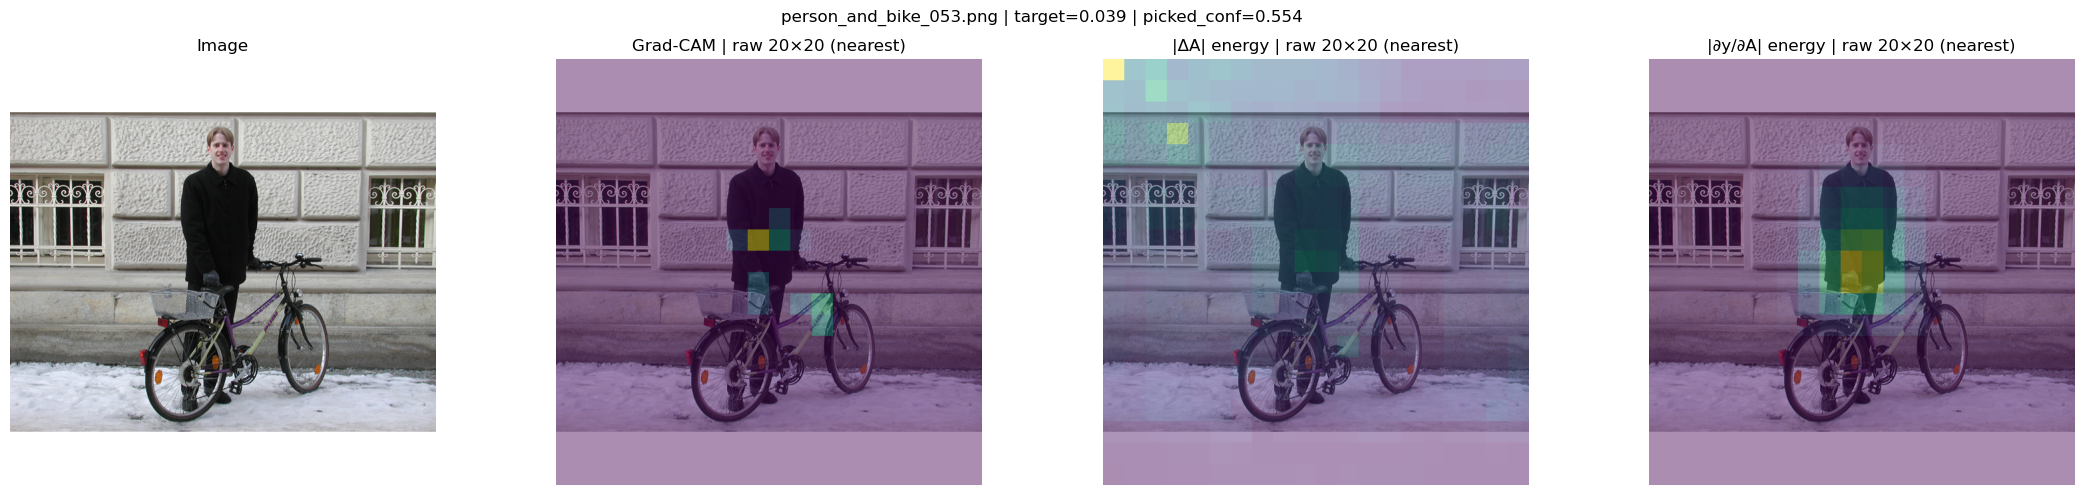

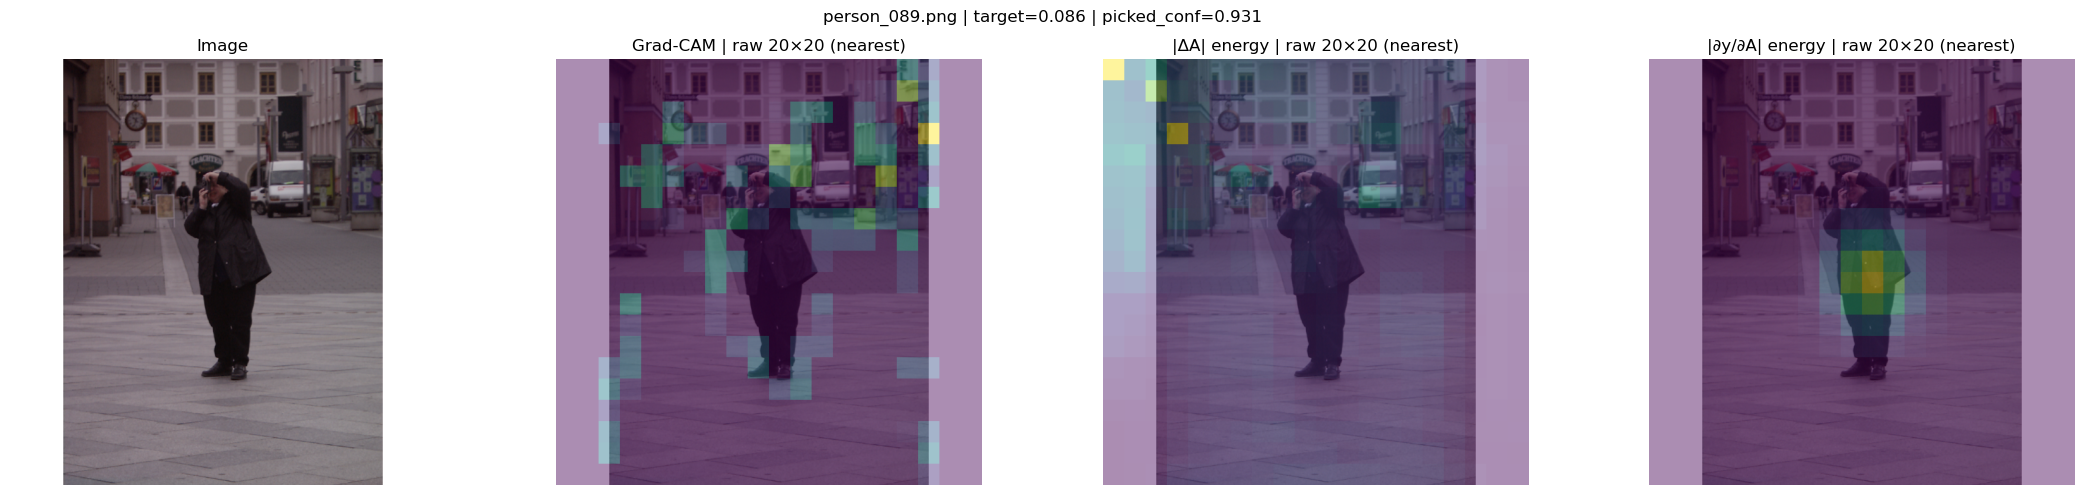

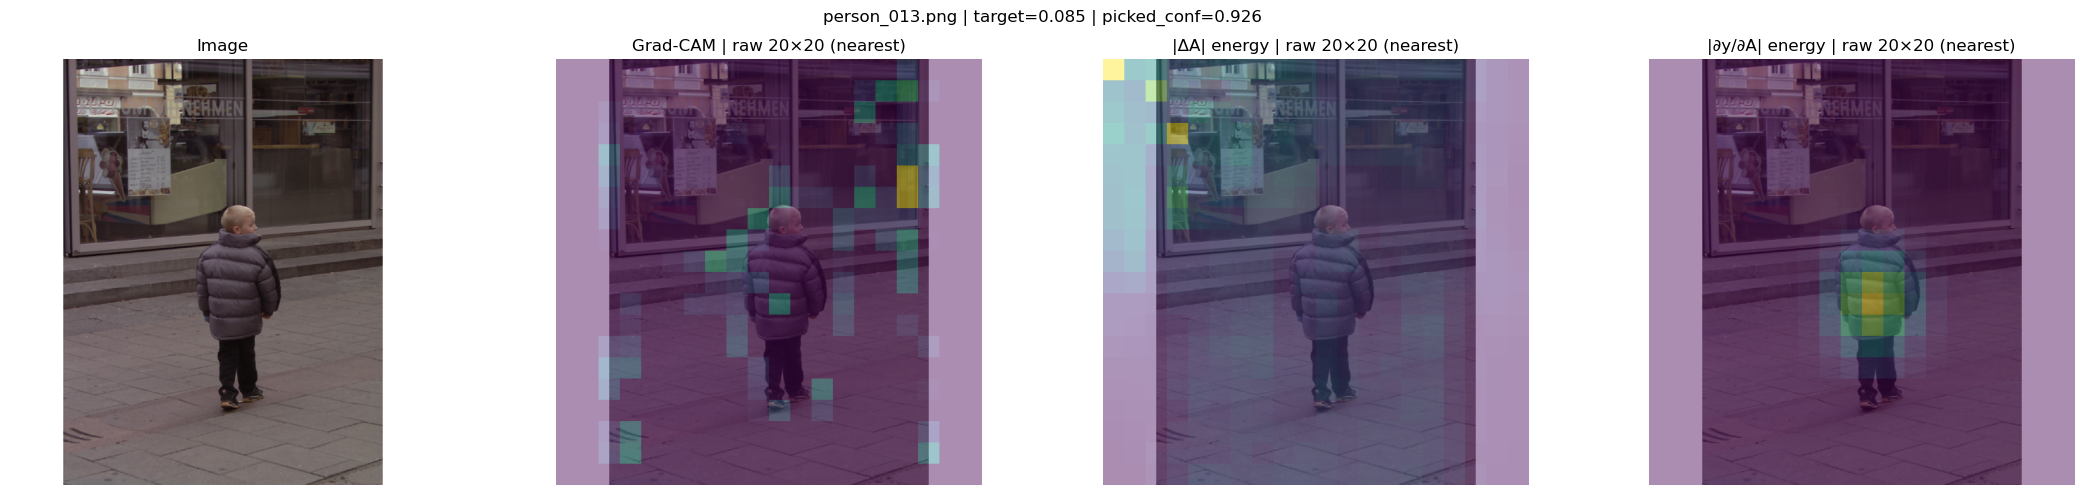

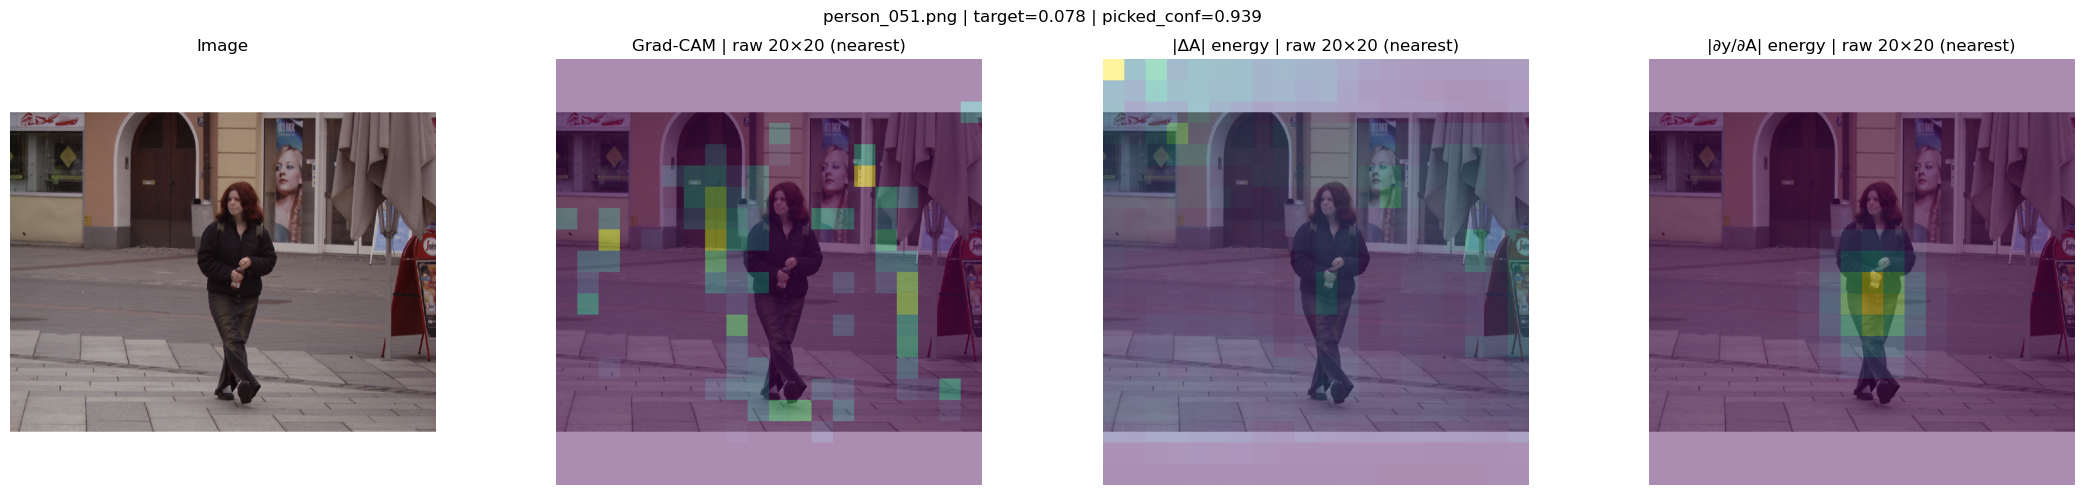

In [30]:
# ---- RUN: pick a few examples and show raw(20x20) vs upsample variants ----
TARGET_LAYER = "model.22"
N_EX = 3

examples = []

# mix of success/fail if available
succ = [d for d in run_data if bool(d["success"])]
fail = [d for d in run_data if (not bool(d["success"]))]
examples = (succ[:N_EX] + fail[:N_EX])

for d in examples:
    info = d.get("gradcam_info", {})
    bbox = info.get("picked_bbox", None)
    if bbox is None:
        continue

    delta = d.get("deltas", {}).get(TARGET_LAYER, None)
    if delta is None:
        continue

    x_clean = torch_preprocess_letterboxed(d["clean_lb"], device=CFG.device, dtype=_MODEL_DTYPE)
    A, G, tgt = layer_grad_and_act_for_bbox_target(
        model_torch,
        x_clean,
        target_layer_name=TARGET_LAYER,
        target_class_id=int(target_class_id),
        imgsz=int(CFG.imgsz),
        bbox_xyxy=tuple(float(x) for x in bbox),
    )

    # raw maps on layer grid (1,1,20,20)
    cam_raw = gradcam_raw_20(A, G)
    grad_raw = grad_energy_raw_20(G)
    delta_raw = delta_energy_raw_20(delta)

    base_title = f"{Path(d['path']).name} | target={tgt:.3f} | picked_conf={info.get('picked_conf', float('nan')):.3f}"

    show_raw_overlays_side_by_side(
        d["clean_lb"],
        cam_raw,
        grad_raw,
        delta_raw,
        title=base_title,
        imgsz=int(CFG.imgsz),
    )

## Численное сравнение: совпадение «важных» и «атакованных» фич

Считаем метрики между:
- I — картой важности (20×20) на слое model.22
- D — картой атакованных фич |ΔA| (20×20)

Цель: найти метрики, которые разделяют success vs fail.
Для каждой метрики рисуем boxplot и ROC/AUC.
Все метрики считаем на raw 20×20 без сглаживания.

Computed rows: 20
                      name  success      drop    target  picked_conf  \
0           person_089.png        0  0.056957  0.085535     0.931276   
1           person_013.png        0  0.043838  0.085219     0.926217   
2  person_and_bike_099.png        1  0.594205  0.039244     0.924877   

   gc_iou_topk    gc_cos  gc_pearson  gc_spearman  gc_delta_in_topI  \
0          0.0  0.295506   -0.043289     0.208507          0.168605   
1          0.0  0.244718   -0.106831     0.128660          0.168164   
2          0.0  0.190011   -0.041549     0.267066          0.179484   

   g_iou_topk     g_cos  g_pearson  g_spearman  g_delta_in_topI  gxa_iou_topk  \
0    0.000000  0.140460  -0.077632    0.279547         0.171404      0.000000   
1    0.000000  0.195596  -0.016460    0.235993         0.185777      0.000000   
2    0.025641  0.318918   0.202208    0.391666         0.240618      0.025641   

    gxa_cos  gxa_pearson  gxa_spearman  gxa_delta_in_topI  
0  0.127199    -0.06571

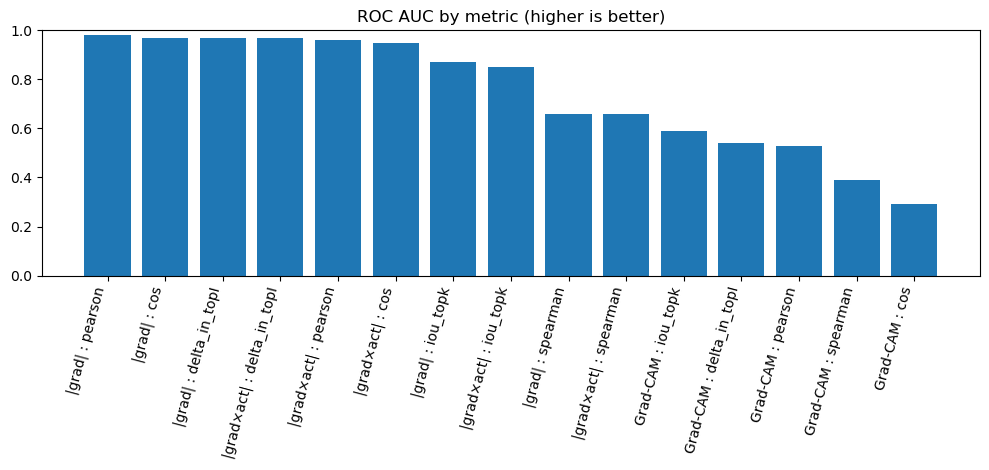

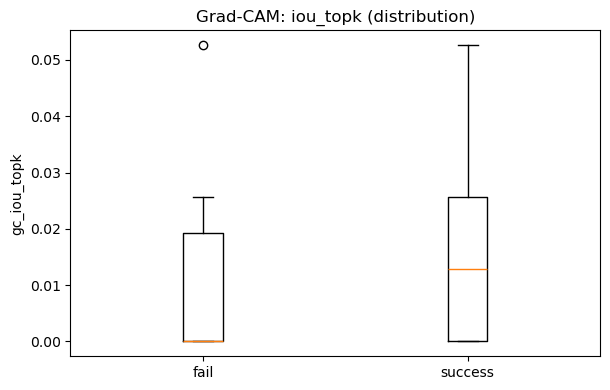

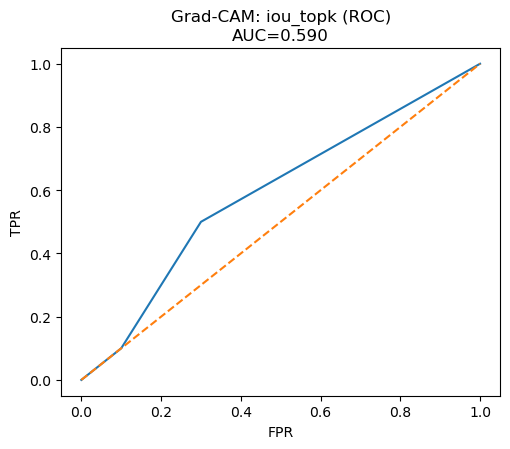

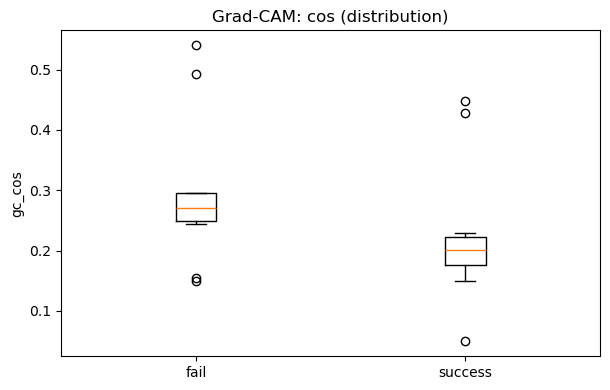

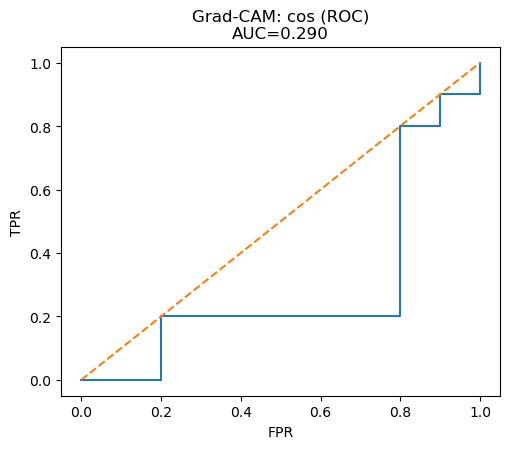

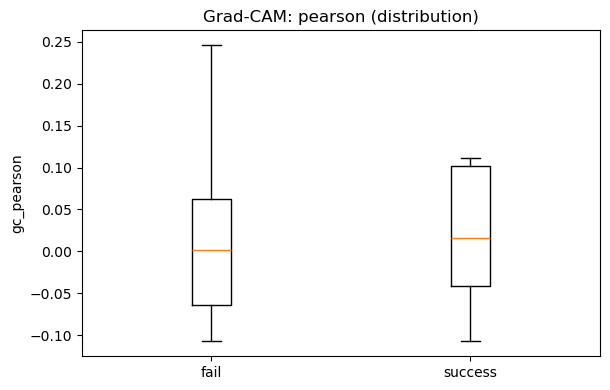

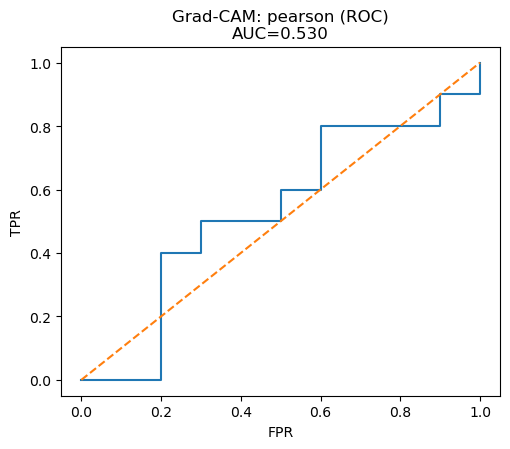

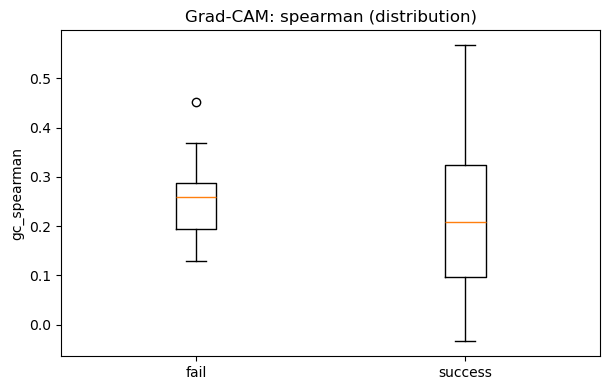

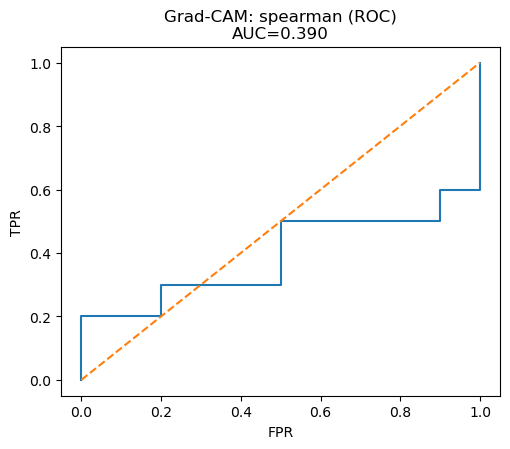

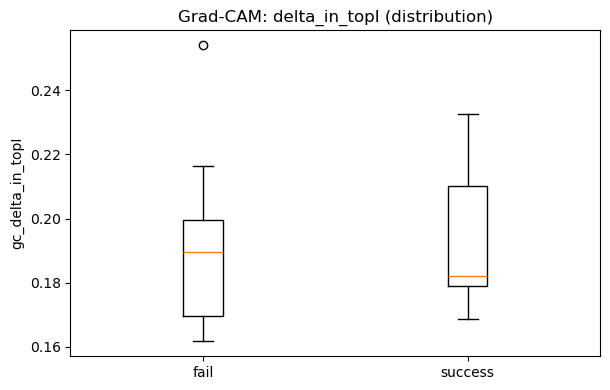

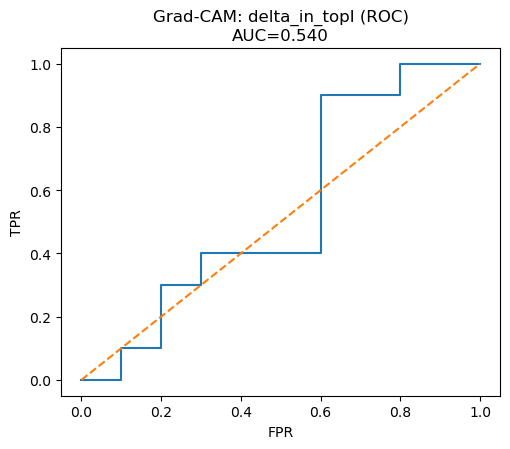

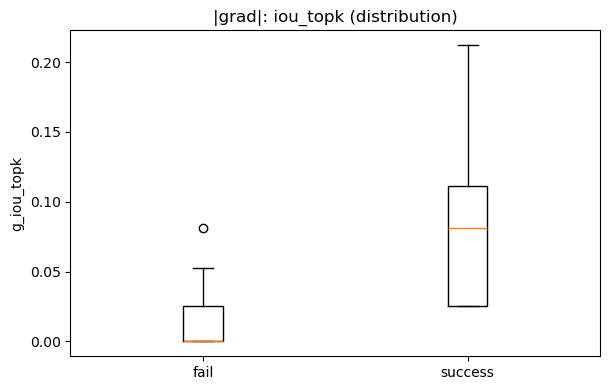

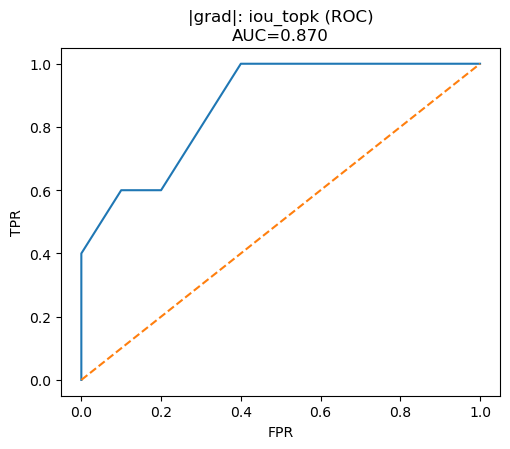

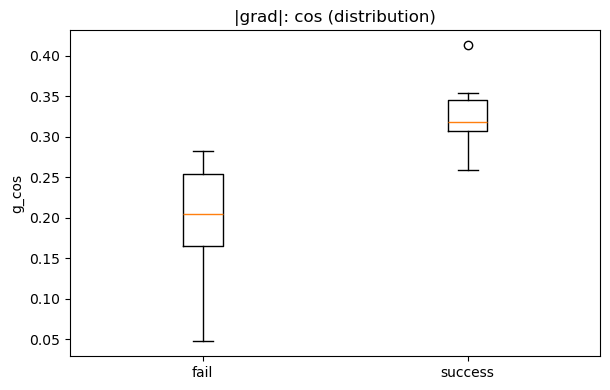

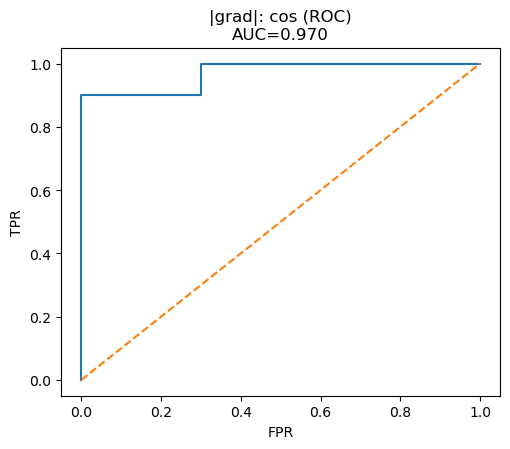

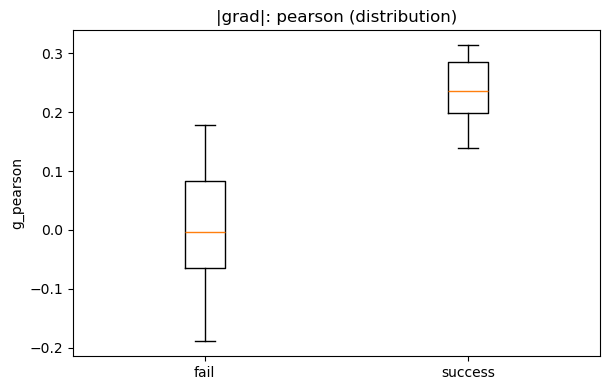

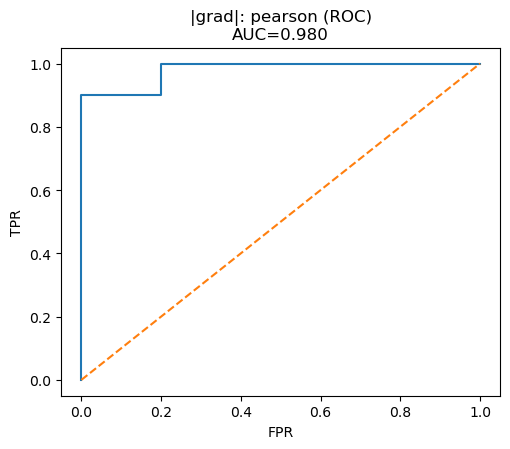

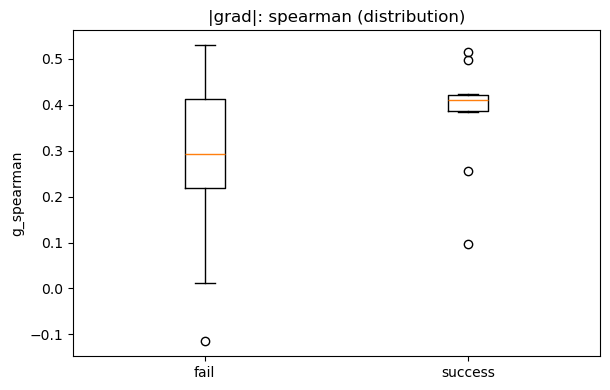

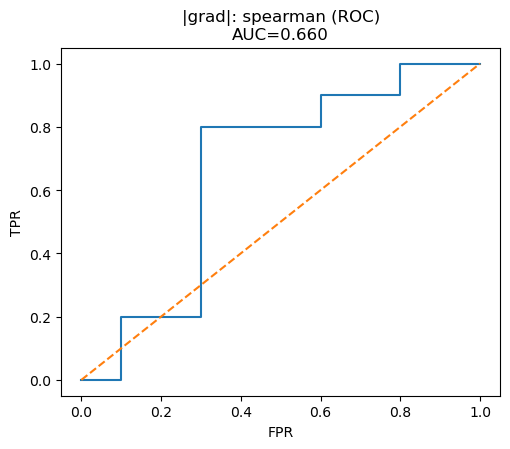

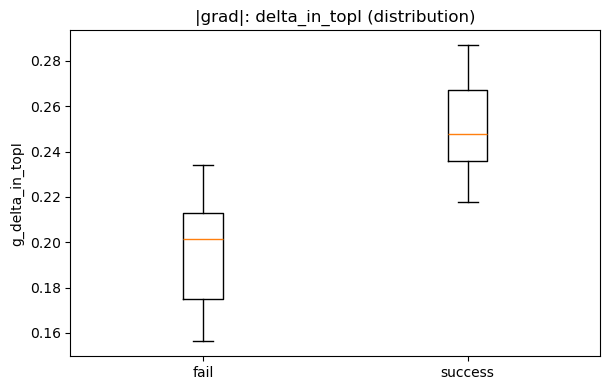

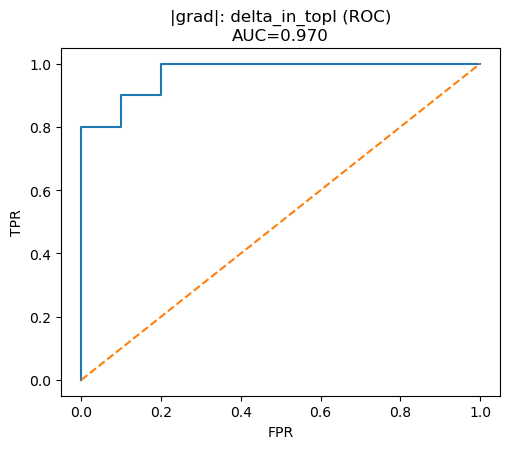

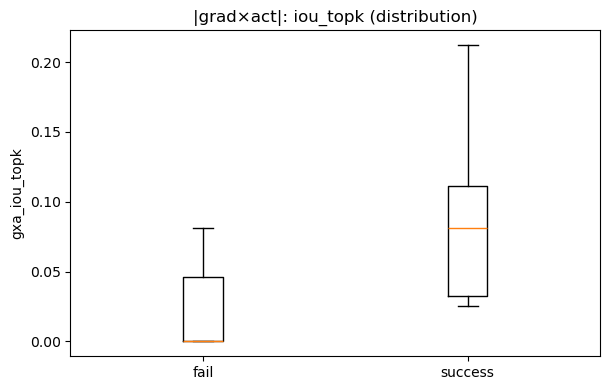

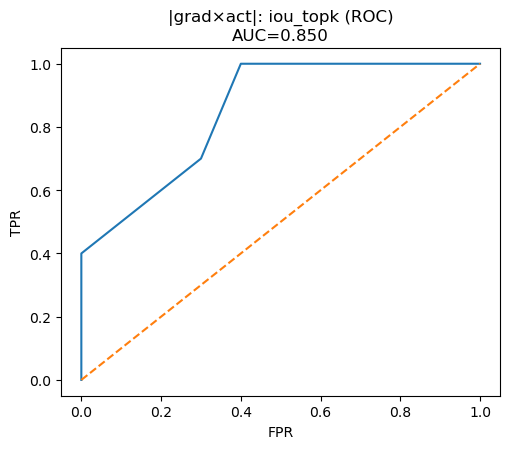

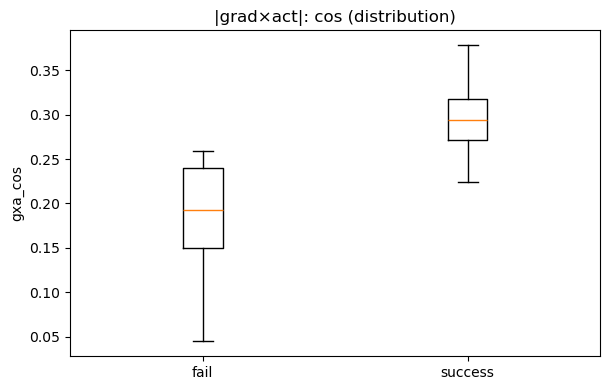

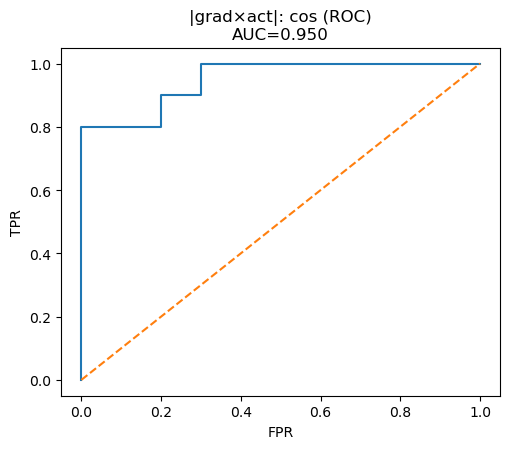

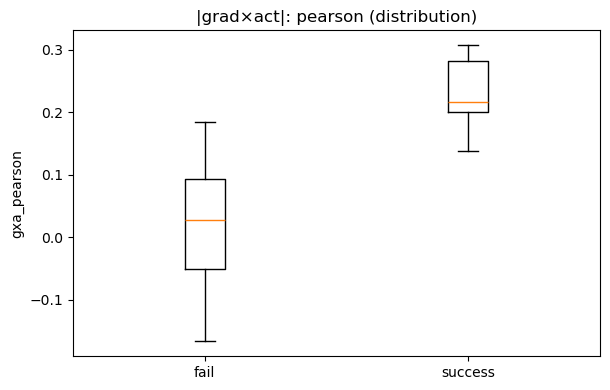

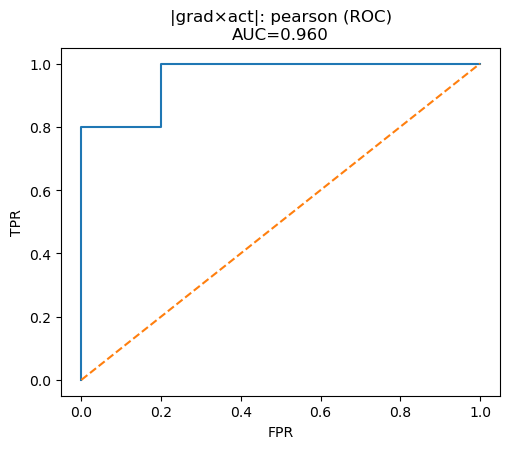

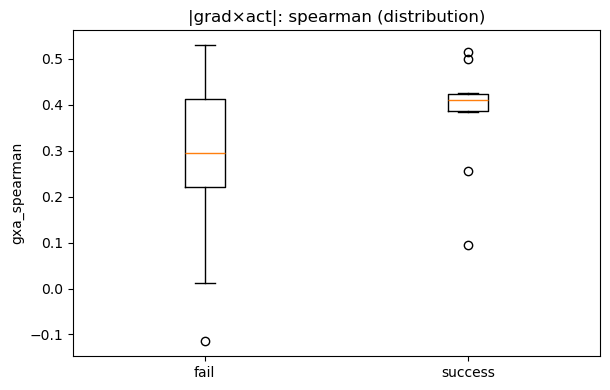

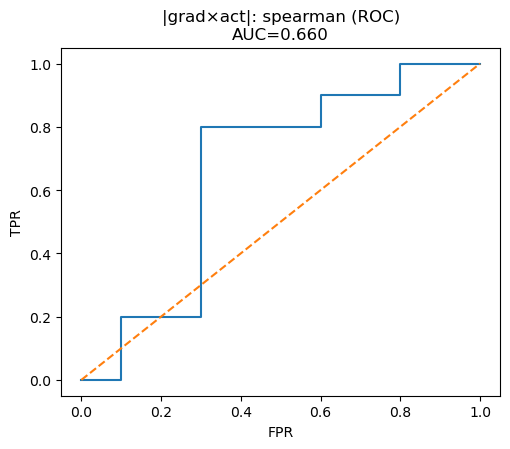

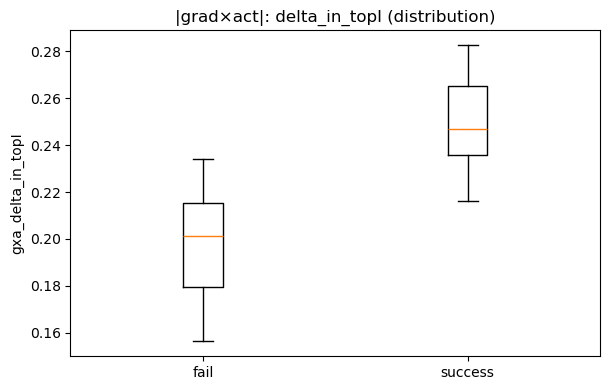

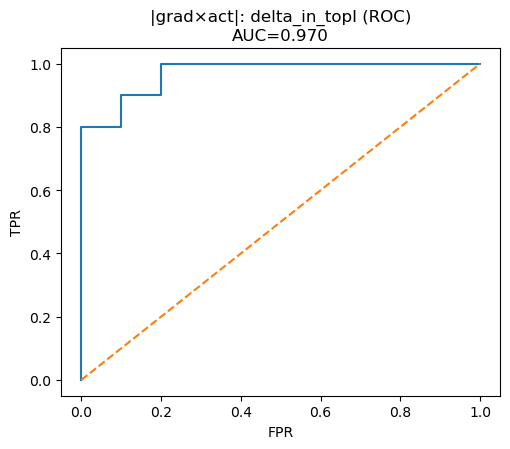

In [37]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- helpers ----------
def _to_np_20(raw_11hw: torch.Tensor) -> np.ndarray:
    return raw_11hw[0, 0].detach().cpu().numpy().astype(np.float32)

def _normalize_np(m: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    m = m.astype(np.float32)
    mn, mx = float(m.min()), float(m.max())
    if mx - mn < eps:
        return np.zeros_like(m, dtype=np.float32)
    return (m - mn) / (mx - mn)

def _flatten(m: np.ndarray) -> np.ndarray:
    return m.reshape(-1).astype(np.float32)

def topk_mask(m: np.ndarray, k: int) -> np.ndarray:
    v = _flatten(m)
    k = int(min(k, v.size))
    if k <= 0:
        return np.zeros_like(m, dtype=bool)
    idx = np.argpartition(-v, k - 1)[:k]
    mask = np.zeros(v.size, dtype=bool)
    mask[idx] = True
    return mask.reshape(m.shape)

def iou_binary(a: np.ndarray, b: np.ndarray) -> float:
    inter = float(np.logical_and(a, b).sum())
    uni = float(np.logical_or(a, b).sum())
    return float(inter / max(1.0, uni))

def weighted_jaccard(a: np.ndarray, b: np.ndarray, eps: float = 1e-12) -> float:
    a = np.clip(a, 0.0, None)
    b = np.clip(b, 0.0, None)
    num = float(np.minimum(a, b).sum())
    den = float(np.maximum(a, b).sum())
    return float(num / max(eps, den))

def cosine_sim(a: np.ndarray, b: np.ndarray, eps: float = 1e-12) -> float:
    a = _flatten(a).astype(np.float64)
    b = _flatten(b).astype(np.float64)
    na, nb = float(np.linalg.norm(a)), float(np.linalg.norm(b))
    if na < eps or nb < eps:
        return 0.0
    return float(np.dot(a, b) / (na * nb))

def pearson_corr(a: np.ndarray, b: np.ndarray, eps: float = 1e-12) -> float:
    a = _flatten(a).astype(np.float64); b = _flatten(b).astype(np.float64)
    a -= a.mean(); b -= b.mean()
    den = float(np.linalg.norm(a) * np.linalg.norm(b))
    if den < eps:
        return 0.0
    return float(np.dot(a, b) / den)

def spearman_corr(a: np.ndarray, b: np.ndarray, eps: float = 1e-12) -> float:
    a = _flatten(a); b = _flatten(b)
    ra = a.argsort().argsort().astype(np.float64)
    rb = b.argsort().argsort().astype(np.float64)
    ra -= ra.mean(); rb -= rb.mean()
    den = float(np.linalg.norm(ra) * np.linalg.norm(rb))
    if den < eps:
        return 0.0
    return float(np.dot(ra, rb) / den)

def energy_overlap_fraction(D: np.ndarray, I: np.ndarray, top_frac: float = 0.2) -> float:
    v = _flatten(I)
    k = int(max(1, round(v.size * float(top_frac))))
    m = topk_mask(I, k)
    num = float(D[m].sum())
    den = float(D.sum())
    return float(num / max(1e-12, den))

def auc_roc(y_true: np.ndarray, scores: np.ndarray) -> float:
    y = y_true.astype(np.int32)
    s = scores.astype(np.float64)
    n_pos = int((y == 1).sum()); n_neg = int((y == 0).sum())
    if n_pos == 0 or n_neg == 0:
        return float("nan")
    order = np.argsort(s)
    ranks = np.empty_like(order, dtype=np.float64)
    ranks[order] = np.arange(1, len(s) + 1, dtype=np.float64)
    # average ranks for ties
    s_sorted = s[order]
    i = 0
    while i < len(s_sorted):
        j = i + 1
        while j < len(s_sorted) and s_sorted[j] == s_sorted[i]:
            j += 1
        if j - i > 1:
            avg = ranks[order[i:j]].mean()
            ranks[order[i:j]] = avg
        i = j
    sum_ranks_pos = float(ranks[y == 1].sum())
    auc = (sum_ranks_pos - n_pos * (n_pos + 1) / 2.0) / (n_pos * n_neg)
    return float(auc)

def roc_curve_points(y_true: np.ndarray, scores: np.ndarray):
    y = y_true.astype(np.int32)
    s = scores.astype(np.float64)
    order = np.argsort(-s)
    y = y[order]; s = s[order]
    P = float((y == 1).sum()); N = float((y == 0).sum())
    if P == 0 or N == 0:
        return np.array([0.0, 1.0]), np.array([0.0, 1.0])
    tp = fp = 0.0
    fpr = [0.0]; tpr = [0.0]
    last_s = None
    for yi, si in zip(y, s):
        if last_s is None:
            last_s = si
        if si != last_s:
            fpr.append(fp / N); tpr.append(tp / P)
            last_s = si
        if yi == 1: tp += 1.0
        else: fp += 1.0
    fpr.append(fp / N); tpr.append(tp / P)
    return np.asarray(fpr), np.asarray(tpr)

def boxplot_metric(vals_fail, vals_succ, title, ylabel):
    plt.figure(figsize=(6.2, 4.0))
    plt.boxplot([vals_fail, vals_succ], tick_labels=["fail", "success"], showfliers=True)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def rocplot_metric(y, s, title):
    auc = auc_roc(y, s)
    fpr, tpr = roc_curve_points(y, s)
    plt.figure(figsize=(5.2, 4.6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(f"{title}\nAUC={auc:.3f}")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.tight_layout()
    plt.show()

# ---------- build per-image metrics ----------
TARGET_LAYER = "model.22"
TOPK_CELLS = 20     # out of 400
TOP_FRAC = 0.20

rows = []

for d in run_data:
    info = d.get("gradcam_info", {})
    bbox = info.get("picked_bbox", None)
    if bbox is None:
        continue

    delta = d.get("deltas", {}).get(TARGET_LAYER, None)
    if delta is None:
        continue

    x_clean = torch_preprocess_letterboxed(d["clean_lb"], device=CFG.device, dtype=_MODEL_DTYPE)
    A, G, tgt = layer_grad_and_act_for_bbox_target(
        model_torch,
        x_clean,
        target_layer_name=TARGET_LAYER,
        target_class_id=int(target_class_id),
        imgsz=int(CFG.imgsz),
        bbox_xyxy=tuple(float(x) for x in bbox),
    )

    # importance maps (raw 20×20)
    I_gc = gradcam_raw_20(A, G)                         # (1,1,20,20)
    I_g  = grad_energy_raw_20(G)                        # (1,1,20,20)
    I_gxa = _normalize_2d((G * A).abs().sum(dim=1, keepdim=True))  # (1,1,20,20)

    # attack map (raw 20×20)
    D = delta_energy_raw_20(delta)                      # (1,1,20,20)

    # to numpy + normalize
    Dn = _normalize_np(_to_np_20(D))
    mkD = topk_mask(Dn, TOPK_CELLS)

    def compute(Iraw: torch.Tensor):
        In = _normalize_np(_to_np_20(Iraw))
        mkI = topk_mask(In, TOPK_CELLS)
        return {
            "iou_topk": iou_binary(mkI, mkD),
            "cos": cosine_sim(In, Dn),
            "pearson": pearson_corr(In, Dn),
            "spearman": spearman_corr(In, Dn),
            "delta_in_topI": energy_overlap_fraction(Dn, In, top_frac=TOP_FRAC),
        }

    m_gc  = compute(I_gc)
    m_g   = compute(I_g)
    m_gxa = compute(I_gxa)

    row = {
        "name": Path(d["path"]).name,
        "success": int(bool(d["success"])),
        "drop": float(d["drop"]),
        "target": float(tgt),
        "picked_conf": float(info.get("picked_conf", np.nan)),
    }
    for pref, mm in [("gc", m_gc), ("g", m_g), ("gxa", m_gxa)]:
        for k, v in mm.items():
            row[f"{pref}_{k}"] = float(v)

    rows.append(row)

import pandas as pd
df = pd.DataFrame(rows)
print("Computed rows:", len(df))
print(df.head(3))

# ---------- AUC summary + plots ----------
families = {"Grad-CAM": "gc", "|grad|": "g", "|grad×act|": "gxa"}
metrics = ["iou_topk", "cos", "pearson", "spearman", "delta_in_topI"]

auc_rows = []
for fam, pref in families.items():
    for m in metrics:
        col = f"{pref}_{m}"
        auc_rows.append({"family": fam, "metric": m, "col": col, "auc": auc_roc(df.success.values, df[col].values)})

auc_df = pd.DataFrame(auc_rows).sort_values("auc", ascending=False)
print("\nTop metrics by AUC:")
print(auc_df.head(12))

# Bar plot of AUC
plt.figure(figsize=(10, 4.8))
order = np.argsort(-auc_df["auc"].values)
vals = auc_df["auc"].values[order]
labels = (auc_df["family"].values[order] + " : " + auc_df["metric"].values[order])
plt.bar(np.arange(len(vals)), vals)
plt.xticks(np.arange(len(vals)), labels, rotation=75, ha="right")
plt.ylim(0.0, 1.0)
plt.title("ROC AUC by metric (higher is better)")
plt.tight_layout()
plt.show()

# For each metric: boxplot + ROC
for fam, pref in families.items():
    for m in metrics:
        col = f"{pref}_{m}"
        s0 = df[df.success == 0][col].dropna().values
        s1 = df[df.success == 1][col].dropna().values
        boxplot_metric(s0, s1, title=f"{fam}: {m} (distribution)", ylabel=col)

        y = df.success.values.astype(np.int32)
        s = df[col].values.astype(np.float64)
        rocplot_metric(y, s, title=f"{fam}: {m} (ROC)")